<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/EKG_GAN_STD5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project description**

Generative Adversial Network for Artificial ECG Generation


# **Install python packages**

In [0]:
!python --version
import keras
!pip3 install scipy keras
print(keras.__version__)


Python 3.6.9


Using TensorFlow backend.


2.3.1


# **Imports**

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path
from timeit import default_timer as timer

# numpy
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

# Basics of Python data handling and visualization

import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io as sio
from timeit import default_timer as timer
import matplotlib as mpl

#keras
from keras.models import Sequential
from keras.layers import Conv1D, TimeDistributed, MaxPooling1D, Dense, Softmax, Flatten, LeakyReLU, Activation, BatchNormalization, Dropout, LSTM, Bidirectional, Reshape
from keras.activations import relu
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.initializers import RandomNormal

#preprocessing
import random
from sklearn import preprocessing
import scipy.stats
from scipy.signal import resample

# **Google drive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # nazov pracovneho priecinku
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

          

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Paths**

In [0]:
#ANNOTATION - nazvy a anotacie/labely
ANNOTATION_PATH = WORKDIR_PATH / "annotFull.mat"
#MATDATA - signal database (.mat)
SINUS_PATH = WORKDIR_PATH / "SINUS"
AF_SV_VR_PATH = WORKDIR_PATH / "AF_SV_VR"
AB_AV_BB_PV_PATH = WORKDIR_PATH / "AB_AV_BB_PV"
OTHER_NOISY_PATH = WORKDIR_PATH / "OTHER_NOISY"

#**Data manipulation** (signals and labels)

In [0]:
matlab_data = sio.loadmat(file_name=ANNOTATION_PATH)
Ydata = matlab_data['YData']
print('Shape of Ydata ->' + str(Ydata.shape)+', 6884 = number of signals, 2 = signal_names,signal_labels')

signal_names = Ydata[:,0] 
signal_names = [str(signal_names).replace('[', '').replace("'", '').replace(']', '') for signal_names in signal_names.tolist()[:]]
#print('Number of signals ->' + str(len(signal_names)))
print('Names of signals ->' + str(signal_names))

signal_labels = Ydata[:,1]
#signal_labels = [str(signal_labels).replace('[', '').replace(']', '').replace(' ','') for signal_labels in signal_labels.tolist()[:]]
#print('Number of labels ->' + str(len(signal_labels)))
print('Signal labels ->' + str(signal_labels))

labels_names = matlab_data['annotLabel']
labels_names = [str(labels_names).replace('[', '').replace("'", '').replace(']', '').replace('', '') for labels_names in labels_names.tolist()[0]]
print('Names of labels ->' + str(labels_names))

# replace("'",'')


Shape of Ydata ->(6884, 2), 6884 = number of signals, 2 = signal_names,signal_labels
Names of signals ->['EB0000018570.mat', 'EB0000018571.mat', 'EB0000018572.mat', 'EB0000018573.mat', 'EB0000018574.mat', 'EB0000018575.mat', 'EB0000018576.mat', 'EB0000018577.mat', 'EB0000018578.mat', 'EB0000018579.mat', 'EB0000018580.mat', 'EB0000018581.mat', 'EB0000018582.mat', 'EB0000018583.mat', 'EB0000018584.mat', 'EB0000018585.mat', 'EB0000018586.mat', 'EB0000018587.mat', 'EB0000018588.mat', 'EB0000018589.mat', 'EB0000018590.mat', 'EB0000018591.mat', 'EB0000018592.mat', 'EB0000018593.mat', 'EB0000018594.mat', 'EB0000018595.mat', 'EB0000018596.mat', 'EB0000018597.mat', 'EB0000018598.mat', 'EB0000018599.mat', 'EB0000018600.mat', 'EB0000018601.mat', 'EB0000018602.mat', 'EB0000018603.mat', 'EB0000018604.mat', 'EB0000018605.mat', 'EB0000018606.mat', 'EB0000018607.mat', 'EB0000018608.mat', 'EB0000018609.mat', 'EB0000018610.mat', 'EB0000018611.mat', 'EB0000018612.mat', 'EB0000018613.mat', 'EB0000018614.m

# **Creating the database**

**Signaly1** = Signals with MULTIPLE labels (including specific type of label)

**Signaly2** = Signals with ONLY one type of label

In [0]:
AF1=[]; SI1=[];SV1=[];VR1=[];OT1=[];AV1=[];BB1=[];AB1=[];PV1=[];NO1=[]
AF2=[]; SI2=[];SV2=[];VR2=[];OT2=[];AV2=[];BB2=[];AB2=[];PV2=[];NO2=[]

def signal_type(i):
  switcher={
      0:AF2,1:SI2,2:SV2,3:VR2,4:OT2,5:AV2,6:BB2,7:AB2,8:PV2,9:NO2,
      10:AF1,11:SI1,12:SV1,13:VR1,14:OT1,15:AV1,16:BB1,17:AB1,18:PV1,19:NO1
    }
  return switcher.get(i,"Invalid number of label")


prefix=['AF2','SI2','SV2','VR2','OT2','AV2','BB2','AB2','PV2','NO1','AF1','SI1','SV1','VR1','OT1','AV1','BB1','AB1','PV1','NO1']

for counter in range(10,20):
  for item in Ydata.tolist():
    if list(item[1][0])[counter-10] == 1:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))


print('Signals with MANY types of labels including specific type of label:')
print('')
print('Number of AF1 signals ->' + str(len(signal_type(10))))
print('Number of SI1 signals ->' + str(len(signal_type(11))))
print('Number of SV1 signals ->' + str(len(signal_type(12))))
print('Number of VR1 signals ->' + str(len(signal_type(13))))
print('Number of OT1 signals ->' + str(len(signal_type(14))))
print('Number of AV1 signals ->' + str(len(signal_type(15))))
print('Number of BB1 signals ->' + str(len(signal_type(16))))
print('Number of AB1 signals ->' + str(len(signal_type(17))))
print('Number of PV1 signals ->' + str(len(signal_type(18))))
print('Number of NO1 signals ->' + str(len(signal_type(19))))
print('')

counter=0
for counter in range(10):
  for item in Ydata.tolist():
    if list(item[1][0])[counter] == 1 and sum(list(item[1][0])) < 2:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))

print('Signals with ONLY one type of label:')
print('')
print('Number of AF2 signals ->' + str(len(signal_type(0))))
print('Number of SI2 signals ->' + str(len(signal_type(1))))
print('Number of SV2 signals ->' + str(len(signal_type(2))))
print('Number of VR2 signals ->' + str(len(signal_type(3))))
print('Number of OT2 signals ->' + str(len(signal_type(4))))
print('Number of AV2 signals ->' + str(len(signal_type(5))))
print('Number of BB2 signals ->' + str(len(signal_type(6))))
print('Number of AB2 signals ->' + str(len(signal_type(7))))
print('Number of PV2 signals ->' + str(len(signal_type(8))))
print('Number of NO2 signals ->' + str(len(signal_type(9))))
print('')

print('Database of signals was created.')

Signals with MANY types of labels including specific type of label:

Number of AF1 signals ->553
Number of SI1 signals ->5942
Number of SV1 signals ->194
Number of VR1 signals ->102
Number of OT1 signals ->88
Number of AV1 signals ->250
Number of BB1 signals ->434
Number of AB1 signals ->418
Number of PV1 signals ->413
Number of NO1 signals ->2183

Signals with ONLY one type of label:

Number of AF2 signals ->267
Number of SI2 signals ->3350
Number of SV2 signals ->89
Number of VR2 signals ->69
Number of OT2 signals ->5
Number of AV2 signals ->0
Number of BB2 signals ->0
Number of AB2 signals ->0
Number of PV2 signals ->0
Number of NO2 signals ->69

Database of signals was created.


##Lead II

Text(0, 0.5, 'Amplitúda [μV]')

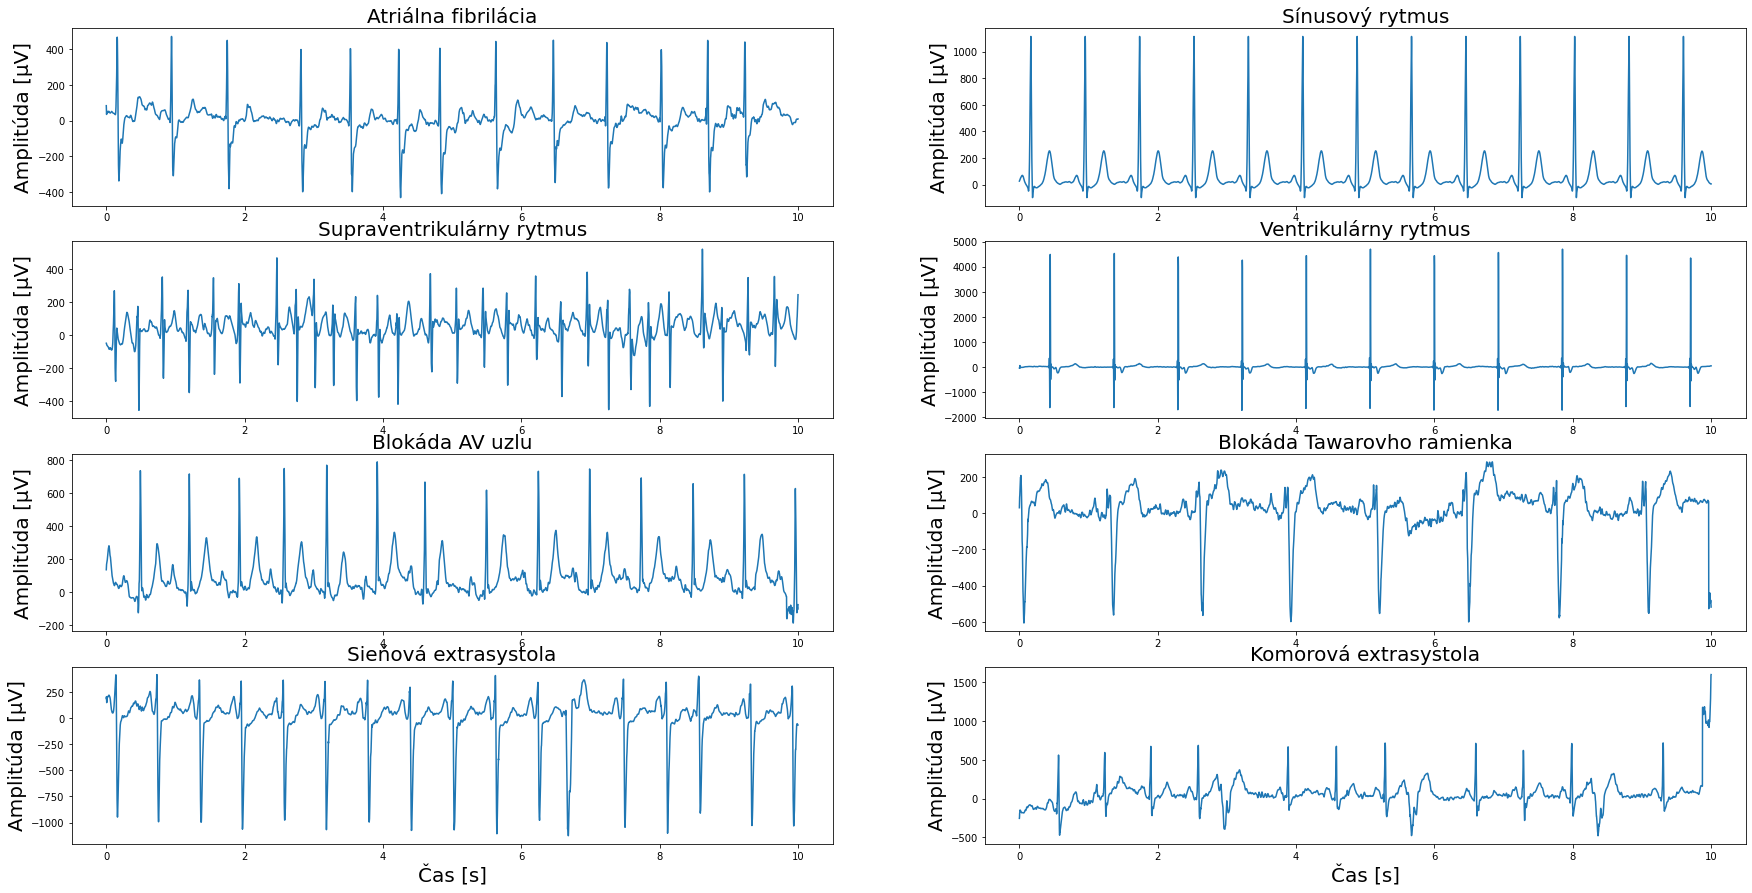

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,0]))
pyplot.title('Atriálna fibrilácia',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,0]))
pyplot.title('Sínusový rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,0]))
pyplot.title('Supraventrikulárny rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,0]))
pyplot.title('Ventrikulárny rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,0]))
pyplot.title('Blokáda AV uzlu',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,0]))
pyplot.title('Blokáda Tawarovho ramienka',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,0]))
pyplot.title('Sieňová extrasystola',fontsize=20)
pyplot.xlabel('Čas [s]',fontsize=20)
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,0]))
pyplot.title('Komorová extrasystola',fontsize=20)
pyplot.xlabel('Čas [s]',fontsize=20)
pyplot.ylabel('Amplitúda [μV]',fontsize=20)


##AvR

Text(0, 0.5, 'Amplitude [μV]')

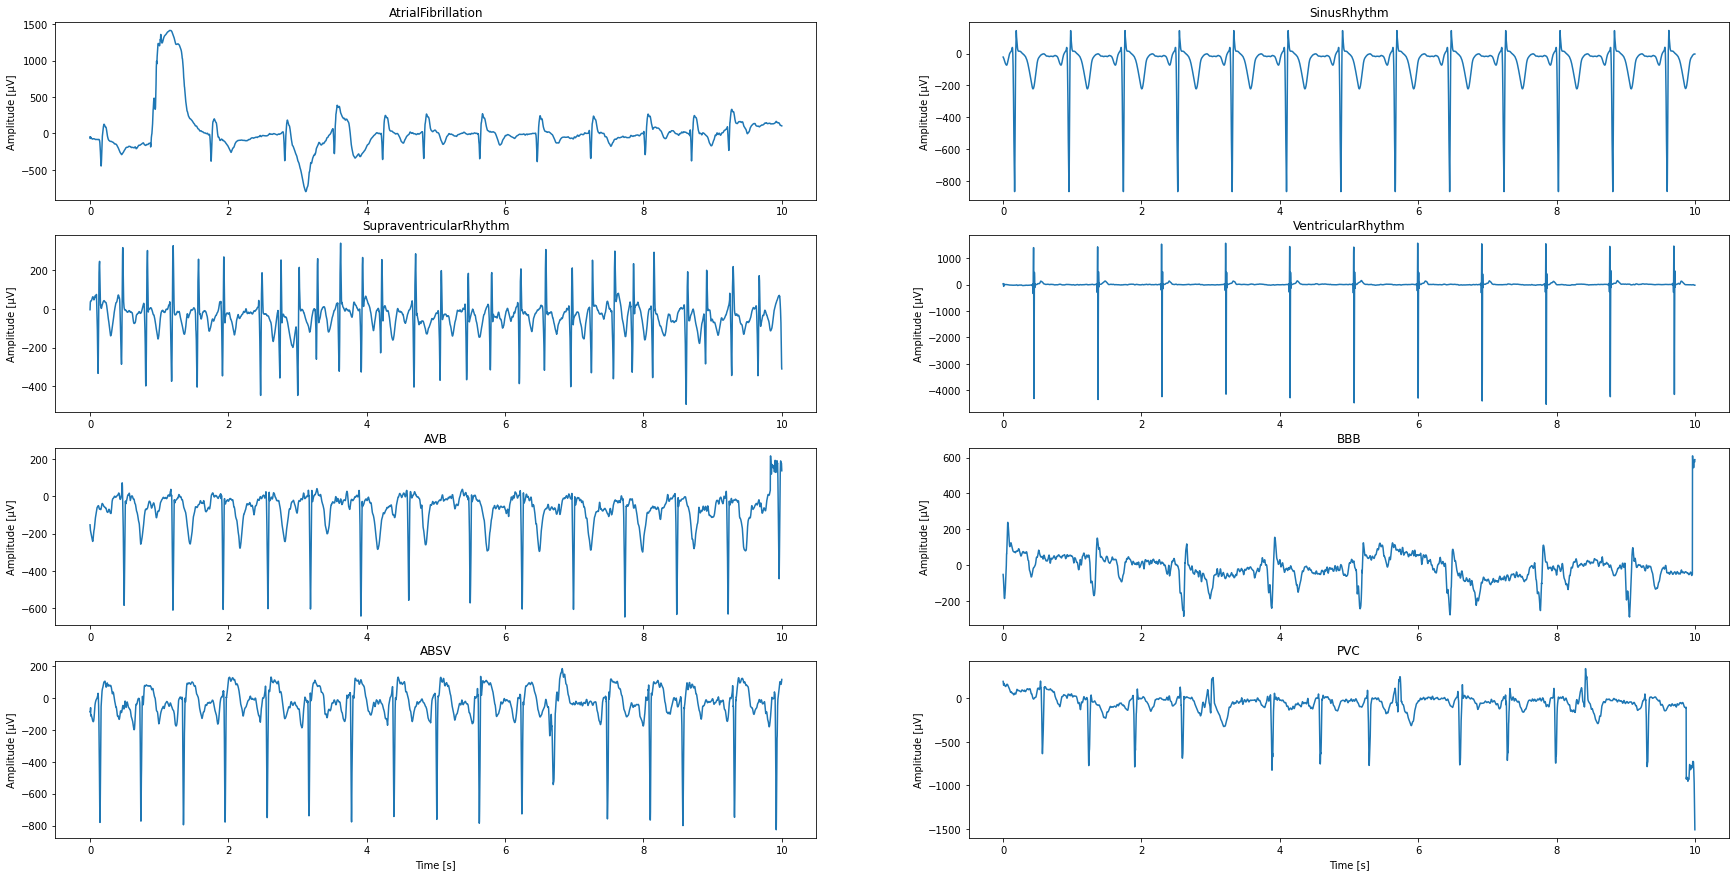

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,1]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,1]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,1]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,1]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,1]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,1]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,1]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,1]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')



##avL

numpy.ndarray

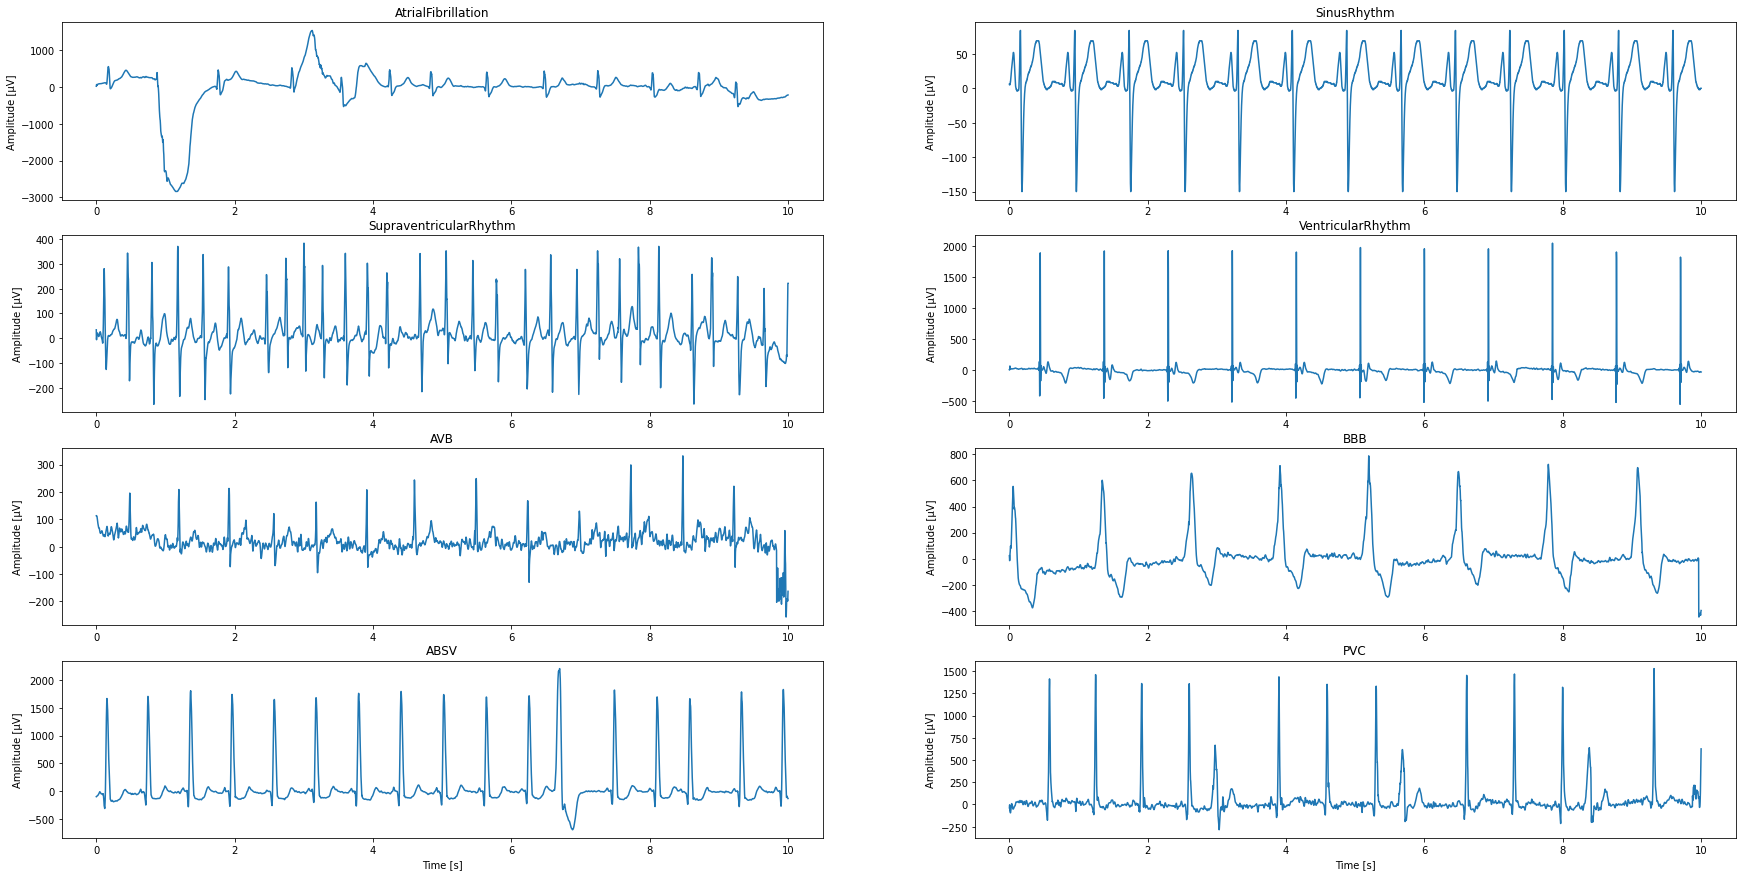

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,2]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,2]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,2]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,2]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,2]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,2]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,2]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,2]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')

type(AF2_signal[:,0])


## Signal loading example

In [0]:
AF2_II=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_II.append(signal[:,0])

AF2_II=np.asarray(AF2_II)

print(np.shape(AF2_II))

AF2_avR=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avR.append(signal[:,1])

AF2_avR=np.asarray(AF2_avR)
print(np.shape(AF2_avR))

AF2_avL=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avL.append(signal[:,2])

AF2_avL=np.asarray(AF2_avL)

print(np.shape(AF2_avL))

labels=np.ones((len(AF2),1))

print(np.shape(labels))

(267, 5000)
(267, 5000)
(267, 5000)
(267, 1)


##Saving sinus signals

In [0]:
# load real samples of sinus rhythm
SI2_II=[]
for i in range(len(SI2)):
  SI2_PATH=SINUS_PATH / SI2[i]
  signal=sio.loadmat(SI2_PATH)
  signal=signal['data']
  SI2_II.append(signal[:,0])

SI2_II=np.asarray(SI2_II)
print(np.shape(SI2_II))
np.save(WORKDIR_PATH / "SI2_II_full",SI2_II)


(3350, 5000)


# **Electrocardiogram generation with a bidirectional LSTM-CNN generative adversarial network**
http://www.nature.com/articles/s41598-019-42516-z


### Signal loading arameters

In [0]:
# which signals to load

#subor= "SI2_II.npy"     # start signaly - 3120 samples from start (0-3120)
#subor="SI2_II_end.npy"  # end signaly - 3120 samples till end (1880-5000)
subor="SI2_II_full.npy"  # full signaly - all 5000 samples (0-5000)

## Preprocessing the input data
* Delete signals that does not fall into range [-1500, 2000]
* Clip them to range [1200, 1200] - easily normalized after
* Normalize inputs to the range [-1, 1] and use tanh in the generator output.

In [0]:
#odstranenie nevhodných signálov
clip_value_top=2000
clip_value_bottom=1500

#orezanie signálov
clip_value_top2=1200
clip_value_bottom2=1200

# vzorkovacia frekvenica (aku chceme)
fvz=360 #500 

In [0]:
SI2_II=np.load(WORKDIR_PATH / subor)
SI2_II=np.transpose(SI2_II)
SI2_II=SI2_II.astype('float32') 

print('Data type of SI2 ->          ' + str(SI2_II.dtype))
print('Type of SI2 ->               ' + str(type(SI2_II)))
print('Shape of SI2 ->              ' + str(np.shape(SI2_II)))

#prevzorkovanie signalu

resampled_signals_360=[]
for i in range(SI2_II.shape[1]):
	resampled_signals_360.append(scipy.signal.resample(SI2_II[:,i],3600))
resampled_signals_360=np.asarray(resampled_signals_360)
resampled_signals_360=np.transpose(resampled_signals_360)

print('Signal resampled from 500Hz to 360Hz ->              ' + str(np.shape(resampled_signals_360)))

#skratenie signalu

SI2_II=resampled_signals_360[479:3599,:]
print('Signal shortened from 3600 to 3120 samples ->              ' + str(np.shape(SI2_II)))

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]

print('Clip value top of SI2 ->         ' + str(clip_value_top) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom) + 'μV')

# orezanie signalov

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top:
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom):
      idx.append(i)

clipped_signals_idx=np.unique(idx)
print('Number of clipped signals -> ' + str(len(clipped_signals_idx)))

SI2_II=np.delete(SI2_II,clipped_signals_idx[:],1)
print('These signals were deleted.')

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]
time_axis=np.linspace(0,length_of_signal/fvz,length_of_signal)

print('Clip value top of SI2 ->         ' + str(clip_value_top2) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom2) + 'μV')

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top2:
      SI2_II[j,i]= clip_value_top2
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom2):
      SI2_II[j,i]= -clip_value_bottom2
      idx.append(i)

print('Number of SI2 signals ->     ' + str(number_of_signals))
print('Length of SI2 signals ->     ' + str(length_of_signal))
print('Time axis :')
print(time_axis)
print('Time axis length is :' + str(len(time_axis)))
print('Max of SI_II_11 :' + str(np.amax(SI2_II)))
print('Min of SI_II_11 :' + str(np.amin(SI2_II)))

# transformacia dat

SI2_II_zscore=scipy.stats.zscore(SI2_II)
SI2_II_01=(SI2_II - np.amin(SI2_II)) / (np.amax(SI2_II) - np.amin(SI2_II))
SI2_II_11=(SI2_II)/clip_value_top2 #1200

print('Shape of Z_score normalization ->     ' + str(np.shape(SI2_II_zscore)))
print('Shape of 01 normalization ->          ' + str(np.shape(SI2_II_01)))
print('Shape of 11 normalization ->          ' + str(np.shape(SI2_II_11)))  

print('Range of Z_score normalization ->     ' + '[' + str(np.amin(SI2_II_zscore)) + ',' + str(np.amax(SI2_II_zscore))+ ']' )
print('Range of 01 normalization ->          ' + '[' + str(np.amin(SI2_II_01)) + ',' + str(np.amax(SI2_II_01))+ ']' )
print('Range of 11 normalization ->          ' + '[' + str(np.amin(SI2_II_11)) + ',' + str(np.amax(SI2_II_11))+ ']' )  

# noisy

noisy_signals=[]
pure = np.linspace(-1, 1, SI2_II.shape[0])
noise = np.random.normal(0, 0.1, pure.shape)
for i in range(SI2_II.shape[1]):
	noisy_signals.append(SI2_II_11[:,i] + noise)
noisy_signals=np.asarray(noisy_signals)
noisy_signals=noisy_signals.reshape(SI2_II.shape[0],SI2_II.shape[1])

print('Range of noisy signals ->          ' + '[' + str(np.amin(noisy_signals)) + ',' + str(np.amax(noisy_signals))+ ']' )  
print('Shape of noisy_signals ->              ' + str(np.shape(noisy_signals)))

Data type of SI2 ->          float32
Type of SI2 ->               <class 'numpy.ndarray'>
Shape of SI2 ->              (5000, 3350)
Signal resampled from 500Hz to 360Hz ->              (3600, 3350)
Signal shortened from 3600 to 3120 samples ->              (3120, 3350)
Clip value top of SI2 ->         2000μV
Clip value bottom of SI2 ->      1500μV
Number of clipped signals -> 55
These signals were deleted.
Clip value top of SI2 ->         1200μV
Clip value bottom of SI2 ->      1200μV
Number of SI2 signals ->     3295
Length of SI2 signals ->     3120
Time axis :
[0.00000000e+00 2.77866838e-03 5.55733675e-03 ... 8.66110933e+00
 8.66388800e+00 8.66666667e+00]
Time axis length is :3120
Max of SI_II_11 :1200.0
Min of SI_II_11 :-1200.0
Shape of Z_score normalization ->     (3120, 3295)
Shape of 01 normalization ->          (3120, 3295)
Shape of 11 normalization ->          (3120, 3295)
Range of Z_score normalization ->     [-8.92911,10.876356]
Range of 01 normalization ->          [0.0,1.0

## Discriminator

* The sequence comprising ECG data points can be regarded as a time series sequence (a normal image requires both a vertical convolution and a horizontal convolution) rather than an image, so only one-dimensional **(1-D) convolution** need to be involved.

* We assume that an input sequence x1, x2, … xT comprises T points, where each is represented by a d-dimensional vector.
 * teda 3120 bodov, kazdy z nich je reprezentoavany jednym bodom v 5D (laten_dim) 
 * input_shape=(None,3120,5) v generatore (None,3120,1) v diskriminatore

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 601, 10)           1210      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 601, 10)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 186, 10)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 51, 5)             1805      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 51, 5)             0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 5)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)               

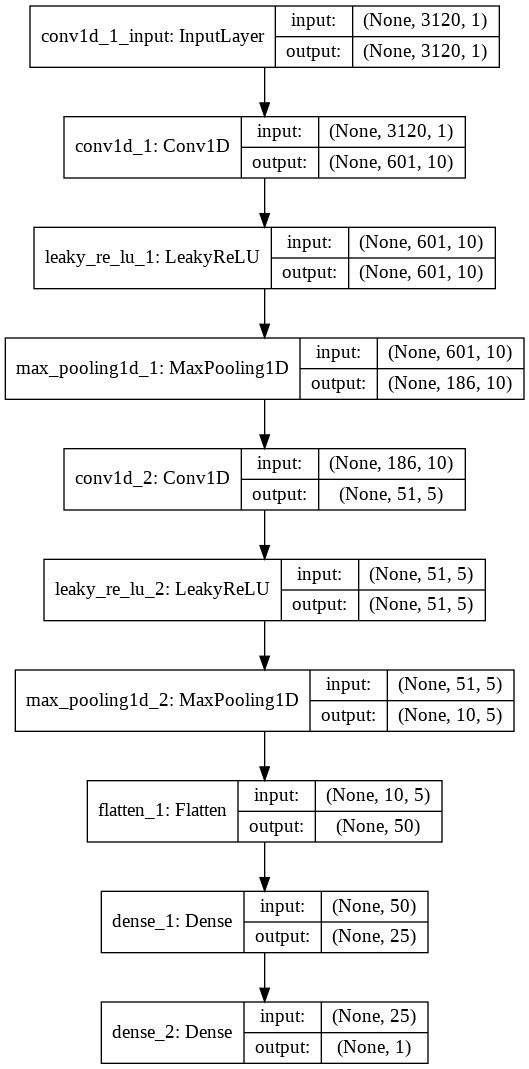

In [0]:
def define_discriminator(input_shape=(3120,1)):
  model = Sequential()
  model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid',kernel_initializer='he_normal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling1D(pool_size=46, strides=3, padding='valid', data_format='channels_last'))
  model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling1D(pool_size=24, strides=3, padding='valid', data_format='channels_last'))
  model.add(Flatten())
  model.add(Dense(25))
  #model.add(Dense(1))
  model.add(Dense(1,activation='sigmoid'))
  # optimalizacny algoritmus
  #adam_D = Adam(lr=0.0002, beta_1=0.5)
  #sgd_D = SGD(lr=0.001) 
  #sgd_D = SGD(lr=0.0001) 
  sgd_D = SGD(lr=0.00001)
  model.compile(loss='binary_crossentropy', optimizer=sgd_D, metrics=['accuracy'])
  return model

# zostavenie diskriminátoru
discriminator_model = define_discriminator()


# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid', data_format='channels_last', dilation_rate=1, 
#                  activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', kernel_regularizer=None, 
#                  bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
#model.add(BatchNormalization())

# model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid', data_format='channels_last', dilation_rate=1, 
#                  activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', 
#                  kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

#NOTES:

# BCEWithLogitsLoss() and Sigmoid() doesn't work together, because BCEWithLogitsLoss() includes the Sigmoid activation. 
# So you can use BCEWithLogitsLoss() without Sigmoid() or you can use Sigmoid() and BCELoss()

# OPTIMALIZATION OPTIONS:

# 0 inicializacia
# 1 Use label smoothing in the discriminator, with small random noise.  
# 2 Add random noise to the labels in the discriminator.
# 3 Add noise to inputs to the discriminator and decay the noise over time.
# 4 Optimalizer / paper= SGD a mini-batch o dlzke 100 / adam je v GANoch standart
#   sgd = SGD(lr=0.00001)
#   adam = Adam(lr=0.0002, beta_1=0.5)
# 5 Remove Fully-Connected Layers
# 6 Use ReLU, Leaky ReLU, and Tanh
# 7 Kernel size, filters, strides

## Generator

*  series of noise data points that follow a Gaussian distribution are fed into the generator as a fixed length sequence. We assume that each noise point can be represented as a d-dimensional **?one-hot vector?** and the length of the sequence is T. Thus, the size of the input matrix is **T × d.** 

* To prevent slow gradient descent due to parameter inflation in the generator, we add a dropout layer and set the probability to 0.5. 

* The generator produces data based on the noise data sampled from a Gaussian distribution, which is **fitted to the real data distribution as accurately as possible.**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="tanh", kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 3120, 100)         84800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 3120, 100)         160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3120, 100)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 3120, 1)           101       
Total params: 245,701
Trainable params: 245,701
Non-trainable params: 0
_________________________________________________________________


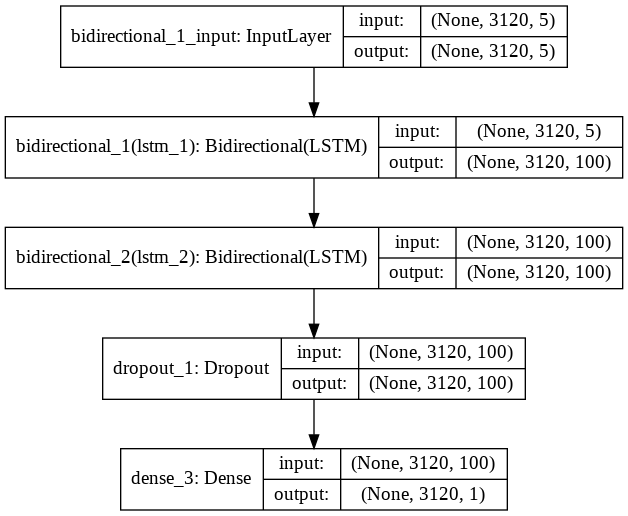

In [0]:
def define_generator(latent_dim):
  model = Sequential()
  model.add(Bidirectional(LSTM(100, return_sequences=True,init='glorot_normal',activation='tanh'), input_shape=(3120,latent_dim), merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Bidirectional(LSTM(100, return_sequences=True,activation='tanh'),merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.5, noise_shape=None, seed=None))
  model.add(Dense(1, activation='tanh'))
  return model

# size of the latent space
latent_dim =5
# define the generator model
generator_model = define_generator(latent_dim)
# summarize the model
generator_model.summary()
# plot the model
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
# recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
# bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
# recurrent_dropout=0.0, implementation=2, return_sequences=True, 
# return_state=False, go_backwards=False, stateful=False, unroll=False),input_shape=(3120,latent_dim), merge_mode='sum'))
# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

#model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
#recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
#bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
#recurrent_dropout=0.0, implementation=2, return_sequences=True, 
#return_state=False, go_backwards=False, stateful=False, unroll=False),merge_mode='sum'))

#latent space method 2

#model.add(Dense(3120*latent_dim, input_dim=latent_dim))
#model.add(LeakyReLU(alpha=0.2))
#model.add(Reshape((3120, latent_dim)))
#model.add(Bidirectional(LSTM(100, return_sequences=True,input_shape=(3120,latent_dim)), merge_mode='sum')) # input_shape=(batch_size,3120,latent_dim)

# NOTES:

# 1 Return sequences - TRUE
# 2 Use dropout of 50 percent during train and generation. - ALREADY USING
# 3 Normalize inputs to the range [-1, 1] and use tanh in the generator output. - DONE
# 4 LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
#   It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. ” alebo [-1,1] ak mam tanh

# OPTIMALIZATION OPTIONS:

# 1 Use Leaky ReLU in the generator and discriminator.
# 2 The best practice for DCAGAN models reported in the paper is to initialize all weights using 
#   a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

## Possible tuning


### https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

### TIPS AND TRICKS:

*   Add random noise to the labels in the discriminator.
*   Add noise to inputs to the discriminator and decay the noise over time.

### ALREADY TRIED:

*   Use label smoothing in the discriminator, with small random noise.**DONE**
*   Use labels if you have them.**DONE**
*   Use dropout of 50 percent during train and generation. **DONE**
*   Normalize inputs to the range [-1, 1] and use tanh in the generator output. - **DONE**
*   Flip the labels and loss function when training the generator. - **DONE**
*   Sample Gaussian random numbers as input to the generator. - **DONE**
*   Use Leaky ReLU in the generator and discriminator. **DONE**
*   Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling. **MAX POOLING, CONV1D**



## Generating fake and real signals



Mean of SI2_II_11_mean :
0.06107788
Std of SI2_II_11_mean :
0.12267831
Latent space points shape:
(5, 3120, 5)
Latent space 5 dimensions, 3120 samples : 
[[[-1.06633157e-01 -9.66565884e-02  1.91975114e-01 -8.55086373e-02
    1.50778410e-01]
  [ 9.62600676e-02  1.34682091e-01 -1.16280845e-01  2.68919991e-02
    2.70070127e-01]
  [-1.84085075e-02  2.22632028e-01 -2.40021651e-01  2.41722896e-01
    5.22344023e-02]
  ...
  [ 1.50101415e-01  8.79298904e-02  2.08657050e-01  1.97280325e-01
   -1.54603055e-02]
  [-2.26292073e-03  2.33858369e-01  2.28722195e-01  1.01487440e-01
   -6.32206415e-02]
  [-8.00480679e-02 -1.73446794e-01  4.81573118e-02  6.25477754e-02
    1.34359127e-01]]

 [[-2.24565633e-02  2.04964121e-01  2.28221239e-01  9.96132799e-02
    2.53373142e-01]
  [ 1.70981505e-01  1.73711261e-01 -2.60240633e-02  1.29494951e-01
    1.44249431e-01]
  [ 1.56044626e-01 -6.05985022e-03  9.19237714e-02 -2.89335501e-02
    2.41599517e-02]
  ...
  [ 4.59472485e-02 -1.95989747e-02  1.67367878e-0

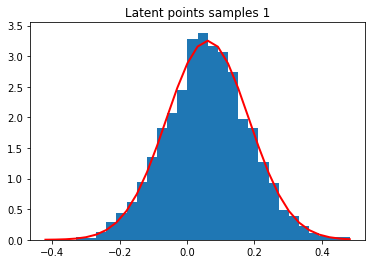

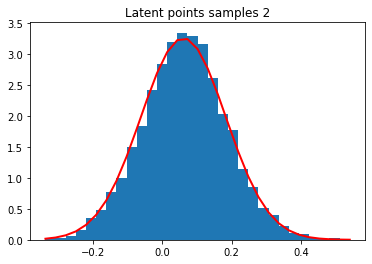

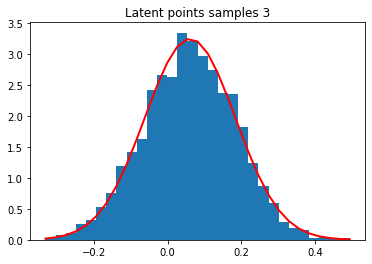

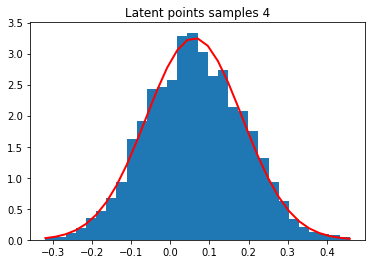

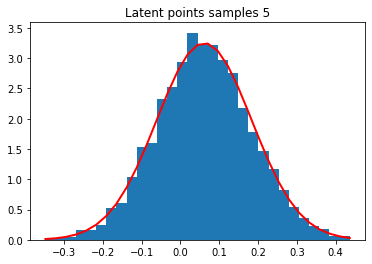

Fake data points shape:
(5, 3120, 1)
Fake data  points [0]:
[-0.01013822 -0.01245199 -0.0147085  ... -0.0160367  -0.01288561
 -0.01028135]


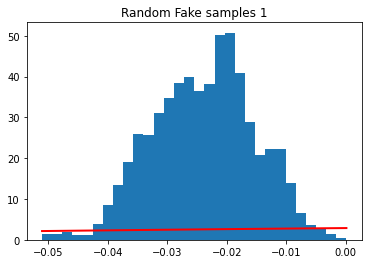

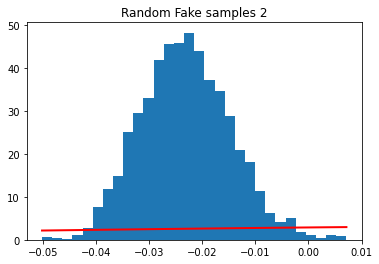

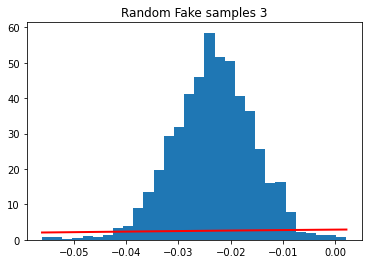

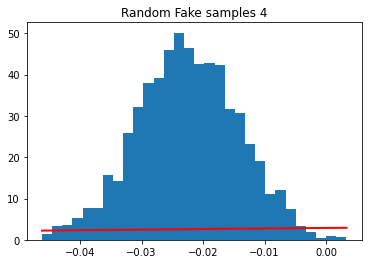

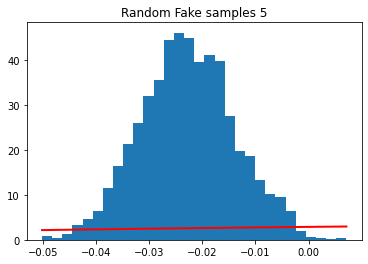

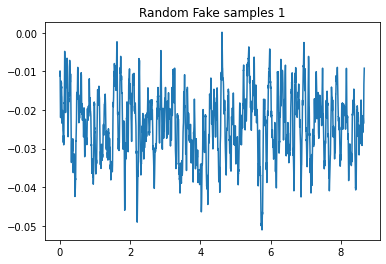

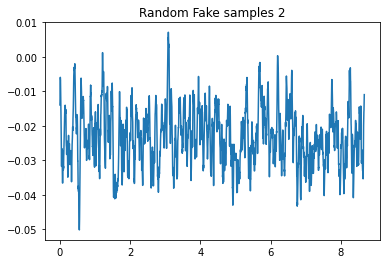

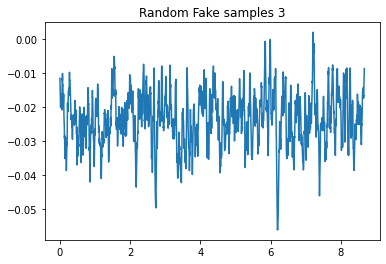

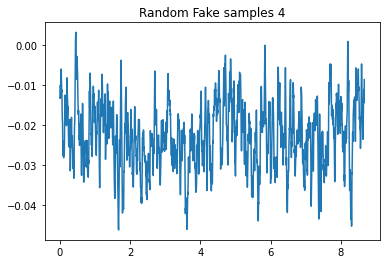

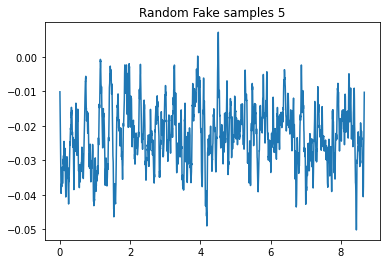

Real data points shape:
(5, 3120, 1)
Real data  points [0]:
[[ 0.10989624]
 [ 0.11093226]
 [ 0.11284087]
 ...
 [-0.02103309]
 [-0.05442125]
 [-0.00993057]]
Length of Real data  points [0]:
3120


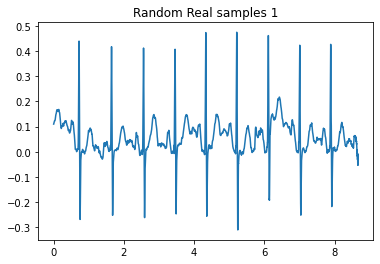

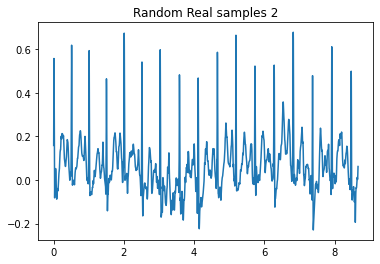

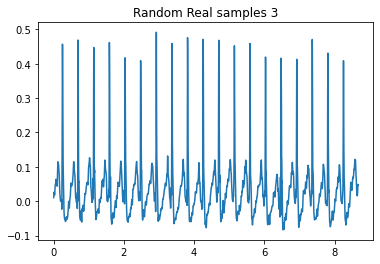

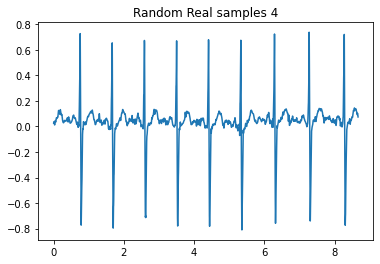

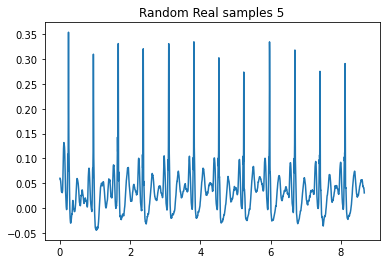

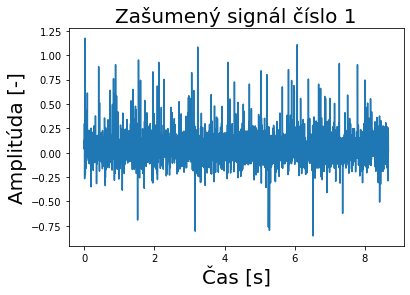

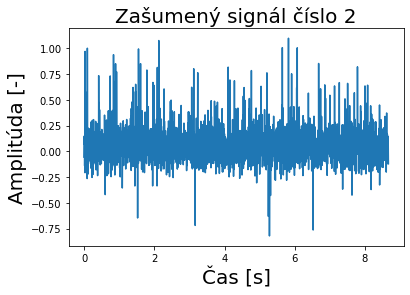

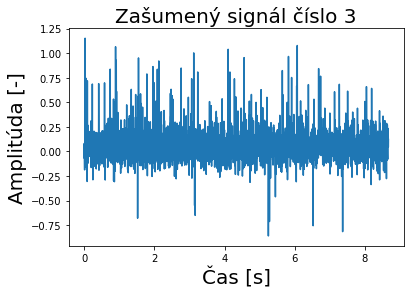

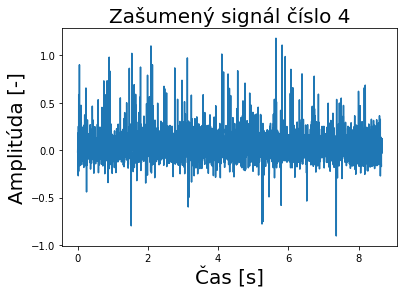

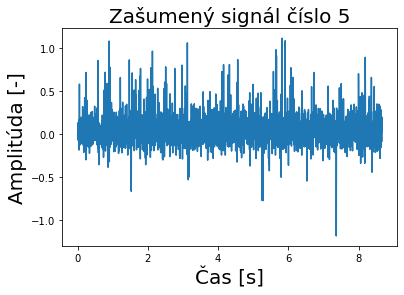

In [0]:
# generovanie latentnych bodov

def generate_latent_points(latent_dim,batch_size,mu,sigma):
  # generate points in the latent space
  latent_points = np.random.normal(mu,sigma, size=(3120 * latent_dim * batch_size))
  latent_points=latent_points.reshape(batch_size,length_of_signal,latent_dim) #batch x 3120 x 5
  return latent_points


# generovanie falosnych signalov

def generate_fake_samples(generator, latent_dim, batch_size,mu,sigma):
  # generovanie latentnych bodov
  X = generate_latent_points(latent_dim, batch_size,mu,sigma)
  x_input = generator_model.predict(X)
  # label smoothing - intervalove oznacenia skupin
  label=[]
  for i in range(batch_size):
    y = np.round(random.uniform(0, 0.1),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.zeros((batch_size,1))
  return x_input,y

# generovanie realnych signalov

def generate_real_samples(batch_size,signal):
  label=[]
  X=[]
  #nahodne cislo signalu
  for i in range (batch_size):
    cislo_signalu=random.randint(0, signal.shape[1]-1)
    X.append(signal[:,cislo_signalu])
  X=np.asarray(X)
  X=X.reshape(batch_size,length_of_signal,1)

  # label smoothing - intervalove oznacenia skupin
  for i in range(batch_size):
    y = np.round(random.uniform(0.9, 1),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.ones((batch_size,1))
  return X,y 

# statistiky signalu pre specificke rozlozenie

SI2_II_11_mean=np.mean(np.mean(SI2_II_11, axis=0))
SI2_II_11_std=np.std(SI2_II_11)
time_axis=np.linspace(0,length_of_signal/360,length_of_signal)

print('Mean of SI2_II_11_mean :')
print(SI2_II_11_mean)
print('Std of SI2_II_11_mean :')
print(SI2_II_11_std)  

latent_points=generate_latent_points(latent_dim=5,batch_size=5,mu=SI2_II_11_mean,sigma=SI2_II_11_std)
print('Latent space points shape:')
print(np.shape(latent_points))
print('Latent space 5 dimensions, 3120 samples : ')
print(latent_points)

#plot latent points

for i in range(5): 
  count, bins, ignored = plt.hist(latent_points[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_11_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_11_mean)**2 / (2 * SI2_II_11_std**2) ), linewidth=2, color='r')
  pyplot.title('Latent points samples'+ ' '+ str(i+1))
  plt.show()

# falosne signaly

fake_data,y = generate_fake_samples(generator_model, latent_dim=5,batch_size=5, mu=SI2_II_11_mean, sigma=SI2_II_11_std)

print('Fake data points shape:')
print(np.shape(fake_data))
print('Fake data  points [0]:')
print(fake_data[i][:,0])

# plot rozlozenia falosnych signalov

for i in range(5): 
  count, bins, ignored = plt.hist(fake_data[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_11_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_11_mean)**2 / (2 * SI2_II_11_std**2) ), linewidth=2, color='r')
  pyplot.title('Random Fake samples'+ ' '+ str(i+1))
  plt.show()

# plot falosnych signalov

for i in range(5): 
  # plot samples
  plt.plot(time_axis, fake_data[i][:,0])
  pyplot.title('Random Fake samples'+ ' '+ str(i+1)) 
  pyplot.show()

# realne signaly

real_data,y = generate_real_samples(5,SI2_II_11)

print('Real data points shape:')
print(np.shape(real_data))
print('Real data  points [0]:')
print(real_data[0])
print('Length of Real data  points [0]:')
print(len(real_data[0]))

# plot realnych signalov

for i in range(5): 
  plt.plot(time_axis, real_data[i])
  pyplot.title('Random Real samples'+ ' '+ str(i+1)) 
  pyplot.show()

# zasumene signaly

for i in range(5): 
  plt.plot(time_axis, noisy_signals[:,i])
  pyplot.title('Zašumený signál číslo'+ ' '+ str(i+1),fontsize=20) 
  pyplot.xlabel('Čas [s]',fontsize=20)
  pyplot.ylabel('Amplitúda [-]',fontsize=20) 
  pyplot.show()

### **As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble signal.**

## Testing the discriminator

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

Therefore, in GAN cases, you don't want D loss to go to zero because that would mean that D is doing a too good job (and most importantly, G a too bad one), ie it can easily discriminate between fake and real data (ie G's creations are not close enough to real data).

In [0]:
start = timer()

# vytvorenie trenovacej a testovacej databazy 80/20 
number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]

print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))
print('Shape of NOISY SI2 signals ->     ' + str(np.shape(noisy_signals)))
	
# testovanie diskriminatora

def test_discriminator(model,train_signals,test_signals,SI2_II_11_mean,SI2_II_11_std, n_iters, batch_size):

	half_batch = int(batch_size / 2)
 
	for i in range(n_iters):

		# realne signaly
		x_real_train, y_real_train = generate_real_samples(half_batch,train_signals)   #50 train real
		x_real_test, y_real_test = generate_real_samples(half_batch,test_signals)			 #50 test real

		# trening diskriminatora
		train_loss, train_acc = model.train_on_batch(x_real_train, y_real_train)
	
		# falosne zasumene signaly
		x_fake,_=generate_real_samples(half_batch,noisy_signals)	#50 noisy
		_, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch, SI2_II_11_mean, SI2_II_11_std) #oznacenia chceme fake=0

		# # falosne signaly z generatoru
		# x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch, SI2_II_11_mean, SI2_II_11_std)		 #50 fake 

		# update discriminator on fake/noisy samples
		loss_fake, fake_acc = model.train_on_batch(x_fake, y_fake)
	
		print('>%d train_acc=%.0f%% fake_acc=%.0f%% 		train_loss=%f fake_loss=%f' % (i+1, train_acc*100, fake_acc*100, train_loss, loss_fake))
		train_acc_graph.append(train_acc)
		train_loss_graph.append(train_loss)
		fake_acc_graph.append(fake_acc)
		loss_fake_graph.append(loss_fake)


train_acc_graph=[]
fake_acc_graph=[]
train_loss_graph=[]
loss_fake_graph=[]

# vytvorenie diskriminatoru
discriminator_model = define_discriminator(input_shape=(3120,1))
# testovanie diskriminatoru
test_discriminator(discriminator_model,SI2_II_11_train,SI2_II_11_test,SI2_II_11_mean,SI2_II_11_std, 200, 200)

end = timer()
print('Time of training:') 
print(end - start) #1520s- 200 iteracii

np.save(WORKDIR_PATH / "train_acc_graph",train_acc_graph)
np.save(WORKDIR_PATH / "fake_acc_graph",fake_acc_graph)
np.save(WORKDIR_PATH / "train_loss_graph",train_loss_graph)
np.save(WORKDIR_PATH / "loss_fake_graph",loss_fake_graph)


Shape of TRAIN SI2 signals->     (3120, 2636)
Shape of TEST SI2 signals ->     (3120, 659)
Shape of NOISY SI2 signals ->     (3120, 3295)
>1 train_acc=0% fake_acc=7% 		train_loss=1.386492 fake_loss=0.291383
>2 train_acc=0% fake_acc=3% 		train_loss=1.353402 fake_loss=0.289954
>3 train_acc=0% fake_acc=8% 		train_loss=1.374537 fake_loss=0.289093
>4 train_acc=0% fake_acc=5% 		train_loss=1.333927 fake_loss=0.295470
>5 train_acc=0% fake_acc=6% 		train_loss=1.401267 fake_loss=0.296701
>6 train_acc=0% fake_acc=7% 		train_loss=1.376778 fake_loss=0.294910
>7 train_acc=0% fake_acc=3% 		train_loss=1.356049 fake_loss=0.288630
>8 train_acc=0% fake_acc=5% 		train_loss=1.324977 fake_loss=0.299633
>9 train_acc=0% fake_acc=4% 		train_loss=1.370451 fake_loss=0.297420
>10 train_acc=0% fake_acc=6% 		train_loss=1.358563 fake_loss=0.298023
>11 train_acc=0% fake_acc=3% 		train_loss=1.334021 fake_loss=0.296329
>12 train_acc=0% fake_acc=11% 		train_loss=1.326675 fake_loss=0.294059
>13 train_acc=0% fake_acc=3% 	

### Analyze discriminator performance
* When things are working, D loss has low variance and goes down over time vs having huge variance and spiking
if loss of generator steadily decreases, then it's fooling D with garbage (says martin)


* Therefore, in GAN cases, you don't want D loss to go to zero because that would mean that D is doing a too good job (and most importantly, G a too bad one), ie it can easily discriminate between fake and real data (ie G's creations are not close enough to real data).


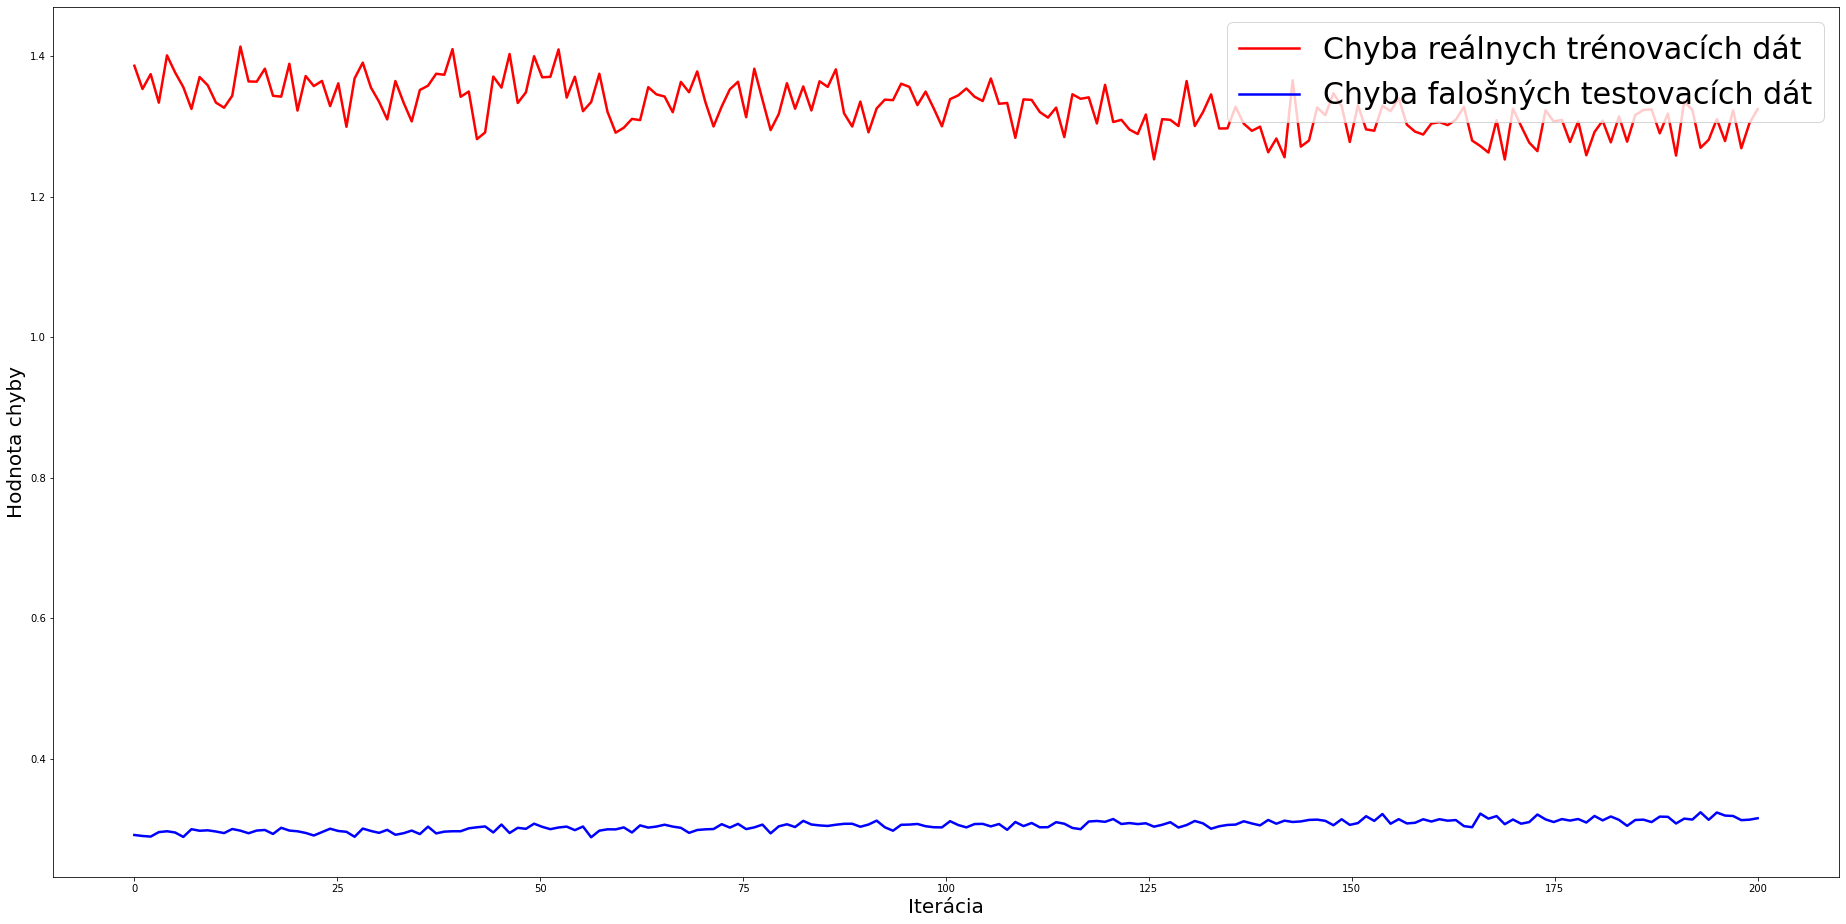

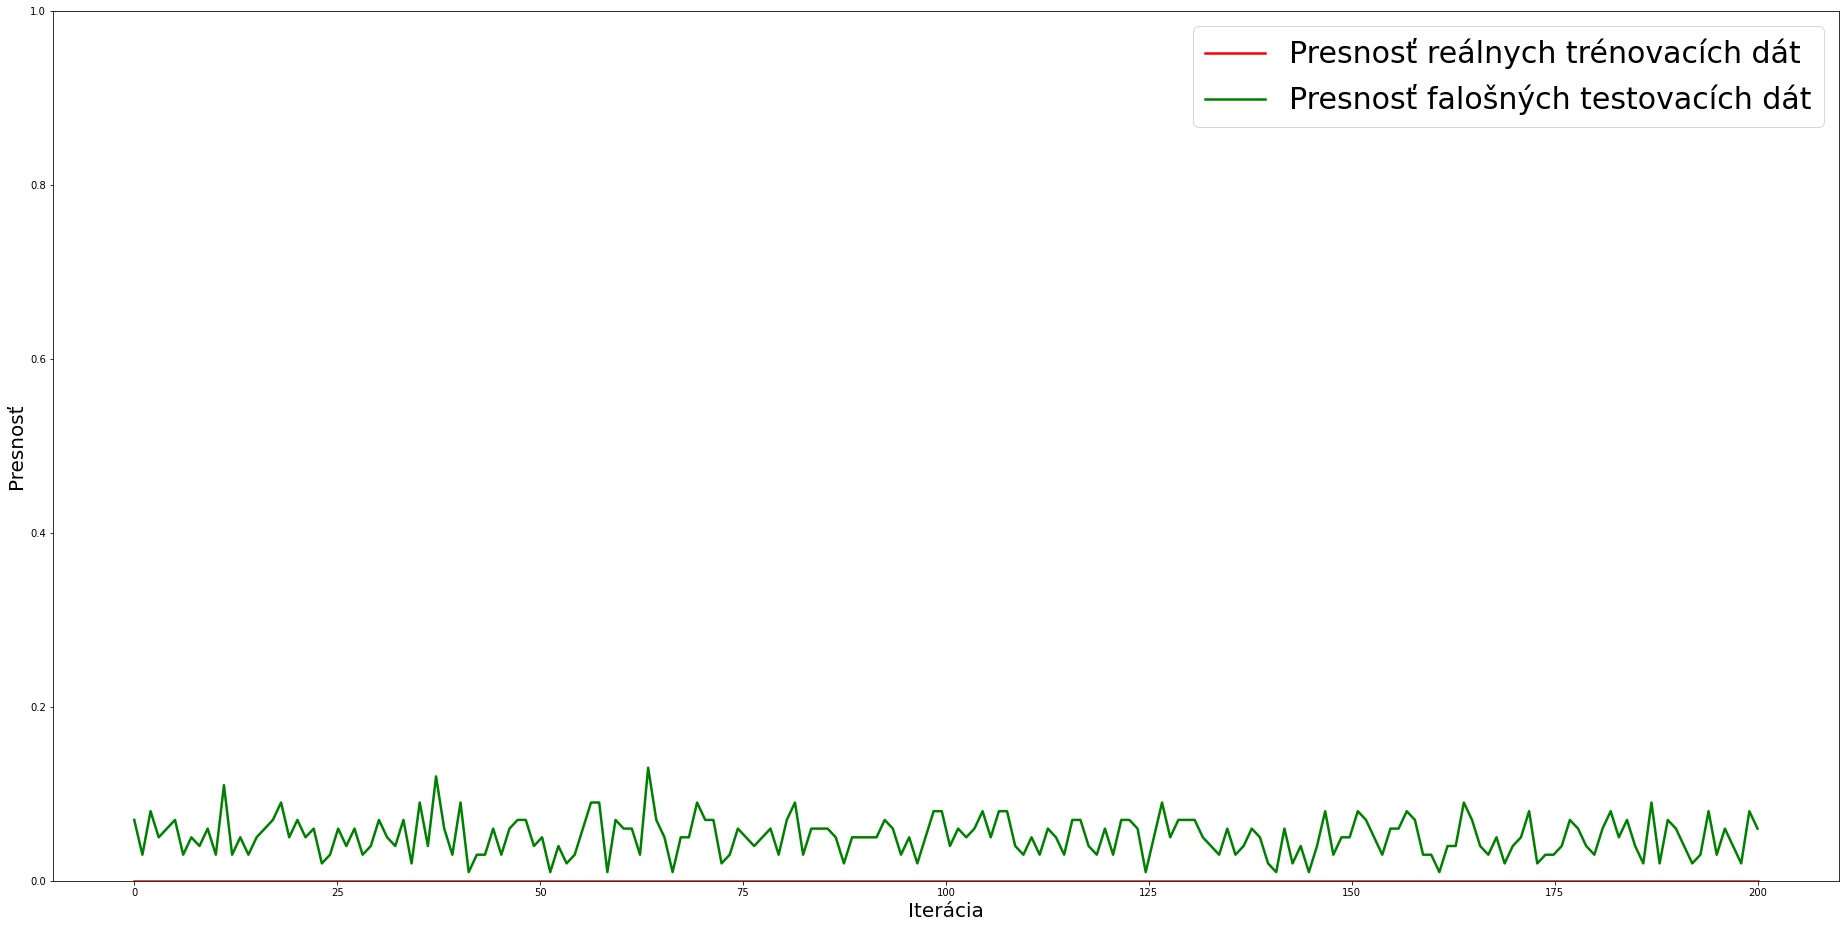

In [0]:
train_acc_graph=np.load(WORKDIR_PATH / "train_acc_graph.npy")
fake_acc_graph=np.load(WORKDIR_PATH / "fake_acc_graph.npy")

train_loss_graph=np.load(WORKDIR_PATH / "train_loss_graph.npy")
loss_fake_graph=np.load(WORKDIR_PATH / "loss_fake_graph.npy")

# filtered_acc_real2 = [ item for i,item in enumerate(d_real_acc_graph2) if i%100==0 ]
# filtered_acc_fake2 = [ item for i,item in enumerate(d_fake_acc_graph2) if i%100==0 ]

iterations=int(np.array(np.shape(train_acc_graph)))

time_axis=np.linspace(0,iterations,iterations)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba reálnych trénovacích dát', 'x': time_axis, 'y': train_loss_graph[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba falošných testovacích dát', 'x': time_axis, 'y': loss_fake_graph[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Hodnota chyby',fontsize=20)
 
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť reálnych trénovacích dát', 'x': time_axis, 'y': train_acc_graph[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť falošných testovacích dát', 'x': time_axis, 'y': fake_acc_graph[:], 'color':'g', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Presnosť',fontsize=20)
  plt.ylim(0,1)

## Submodel for generator training

* Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

* To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

* The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

* When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

* We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

Gan model summary :
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 3120, 1)           245701    
_________________________________________________________________
sequential_19 (Sequential)   (None, 1)                 4316      
Total params: 250,017
Trainable params: 245,701
Non-trainable params: 4,316
_________________________________________________________________
Gan model plot: 


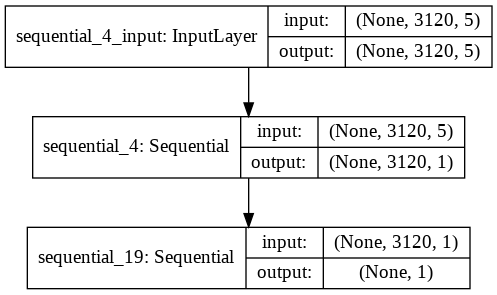

In [0]:
# submodel pre trenovanie generatoru

def define_gan(generator, discriminator):
	# zmrazenie vah diskriminatoru
	discriminator.trainable = False
	# prepojenie modelov
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# optimalizacny algoritmus generatoru
	#adam = Adam(lr=0.0002, beta_1=0.5)
	#sgd = SGD(lr=0.001) 
	#sgd = SGD(lr=0.0001) 
	sgd = SGD(lr=0.00001)
	model.compile(loss='binary_crossentropy', optimizer=sgd)
	return model

# vytvorenie submodelu
gan_model = define_gan(generator_model, discriminator_model)

# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Training GAN - complete model

### Notes from EKG paper:

*  Each model was trained for **500 epochs** with a **mini-batch size of 100**, where the length of the sequence comprised a series of ECG 3120 points and the learning rate was **1 × 10−5.** 

*  The dim for the noise data points was set to **5** and the **length of the generated ECGs was 400.** 

The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher.

For example, I came across: Make the discriminator much less expressive by using a smaller model. Generation is a much harder task and requires more parameters, so the generator should be significantly bigger. [1]

Shape of TRAIN SI2 signals->     (3120, 2636)
Shape of TEST SI2 signals ->     (3120, 659)
Mean of SI2_II_11_train_mean :
0.060996685
Std of SI2_II_11_train_std :
0.11372057


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="tanh", kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/16, d_real=3% d_fake=0%     		d_loss=1.069195  g_loss=0.618846
>1, 2/16, d_real=10% d_fake=0%     		d_loss=1.040079  g_loss=0.618832
>1, 3/16, d_real=6% d_fake=0%     		d_loss=1.049434  g_loss=0.619071
>1, 4/16, d_real=3% d_fake=0%     		d_loss=1.047760  g_loss=0.617041
>1, 5/16, d_real=2% d_fake=0%     		d_loss=1.048448  g_loss=0.618735
>1, 6/16, d_real=7% d_fake=0%     		d_loss=1.055602  g_loss=0.617637
>1, 7/16, d_real=9% d_fake=0%     		d_loss=1.050103  g_loss=0.617728
>1, 8/16, d_real=4% d_fake=0%     		d_loss=1.060175  g_loss=0.617175
>1, 9/16, d_real=7% d_fake=0%     		d_loss=1.053409  g_loss=0.617557
>1, 10/16, d_real=3% d_fake=0%     		d_loss=1.042421  g_loss=0.616837
>1, 11/16, d_real=3% d_fake=0%     		d_loss=1.060028  g_loss=0.617010
>1, 12/16, d_real=6% d_fake=0%     		d_loss=1.056233  g_loss=0.618176
>1, 13/16, d_real=4% d_fake=0%     		d_loss=1.049927  g_loss=0.616491
>1, 14/16, d_real=3% d_fake=0%     		d_loss=1.055520  g_loss=0.618420
>1, 15/16, d_real=4% d_fake=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>3, 1/16, d_real=2% d_fake=0%     		d_loss=1.041037  g_loss=0.613159
>3, 2/16, d_real=6% d_fake=0%     		d_loss=1.057565  g_loss=0.614269
>3, 3/16, d_real=4% d_fake=0%     		d_loss=1.059965  g_loss=0.614680
>3, 4/16, d_real=10% d_fake=0%     		d_loss=1.055035  g_loss=0.614145
>3, 5/16, d_real=5% d_fake=0%     		d_loss=1.066887  g_loss=0.612416
>3, 6/16, d_real=8% d_fake=0%     		d_loss=1.044642  g_loss=0.613008
>3, 7/16, d_real=6% d_fake=0%     		d_loss=1.064417  g_loss=0.611540
>3, 8/16, d_real=5% d_fake=0%     		d_loss=1.056379  g_loss=0.612011
>3, 9/16, d_real=7% d_fake=0%     		d_loss=1.065444  g_loss=0.612867
>3, 10/16, d_real=4% d_fake=0%     		d_loss=1.065314  g_loss=0.611705
>3, 11/16, d_real=5% d_fake=0%     		d_loss=1.061641  g_loss=0.612065
>3, 12/16, d_real=5% d_fake=0%     		d_loss=1.049299  g_loss=0.611865
>3, 13/16, d_real=6% d_fake=0%     		d_loss=1.059825  g_loss=0.611167
>3, 14/16, d_real=9% d_fake=0%     		d_loss=1.056159  g_loss=0.610722
>3, 15/16, d_real=8% d_fake=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>5, 1/16, d_real=2% d_fake=0%     		d_loss=1.049459  g_loss=0.606789
>5, 2/16, d_real=3% d_fake=0%     		d_loss=1.046757  g_loss=0.607928
>5, 3/16, d_real=6% d_fake=0%     		d_loss=1.054511  g_loss=0.607369
>5, 4/16, d_real=6% d_fake=0%     		d_loss=1.052321  g_loss=0.607019
>5, 5/16, d_real=3% d_fake=0%     		d_loss=1.062122  g_loss=0.605651
>5, 6/16, d_real=4% d_fake=0%     		d_loss=1.061582  g_loss=0.605730
>5, 7/16, d_real=2% d_fake=0%     		d_loss=1.058158  g_loss=0.606194
>5, 8/16, d_real=6% d_fake=0%     		d_loss=1.059212  g_loss=0.606286
>5, 9/16, d_real=4% d_fake=0%     		d_loss=1.057083  g_loss=0.606166
>5, 10/16, d_real=5% d_fake=0%     		d_loss=1.056010  g_loss=0.607263
>5, 11/16, d_real=2% d_fake=0%     		d_loss=1.054966  g_loss=0.605565
>5, 12/16, d_real=8% d_fake=0%     		d_loss=1.037609  g_loss=0.605468
>5, 13/16, d_real=8% d_fake=0%     		d_loss=1.056345  g_loss=0.605871
>5, 14/16, d_real=5% d_fake=0%     		d_loss=1.039385  g_loss=0.604862
>5, 15/16, d_real=3% d_fake=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>7, 1/16, d_real=1% d_fake=0%     		d_loss=1.064409  g_loss=0.602753
>7, 2/16, d_real=7% d_fake=0%     		d_loss=1.049053  g_loss=0.602196
>7, 3/16, d_real=2% d_fake=0%     		d_loss=1.048010  g_loss=0.601855
>7, 4/16, d_real=6% d_fake=0%     		d_loss=1.055802  g_loss=0.600952
>7, 5/16, d_real=3% d_fake=0%     		d_loss=1.040927  g_loss=0.600460
>7, 6/16, d_real=9% d_fake=0%     		d_loss=1.053506  g_loss=0.601160
>7, 7/16, d_real=6% d_fake=0%     		d_loss=1.065594  g_loss=0.600269
>7, 8/16, d_real=6% d_fake=0%     		d_loss=1.044038  g_loss=0.600760
>7, 9/16, d_real=3% d_fake=0%     		d_loss=1.056455  g_loss=0.598262
>7, 10/16, d_real=6% d_fake=0%     		d_loss=1.052967  g_loss=0.599927
>7, 11/16, d_real=6% d_fake=0%     		d_loss=1.044313  g_loss=0.599545
>7, 12/16, d_real=6% d_fake=0%     		d_loss=1.058461  g_loss=0.601585
>7, 13/16, d_real=2% d_fake=0%     		d_loss=1.048223  g_loss=0.598282
>7, 14/16, d_real=5% d_fake=0%     		d_loss=1.061070  g_loss=0.600465
>7, 15/16, d_real=5% d_fake=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>9, 1/16, d_real=1% d_fake=0%     		d_loss=1.048898  g_loss=0.595510
>9, 2/16, d_real=5% d_fake=0%     		d_loss=1.047524  g_loss=0.596822
>9, 3/16, d_real=3% d_fake=0%     		d_loss=1.060543  g_loss=0.595912
>9, 4/16, d_real=5% d_fake=0%     		d_loss=1.050832  g_loss=0.594995
>9, 5/16, d_real=8% d_fake=0%     		d_loss=1.063002  g_loss=0.595322
>9, 6/16, d_real=10% d_fake=0%     		d_loss=1.047702  g_loss=0.595340
>9, 7/16, d_real=5% d_fake=0%     		d_loss=1.053616  g_loss=0.594784
>9, 8/16, d_real=2% d_fake=0%     		d_loss=1.043474  g_loss=0.594986
>9, 9/16, d_real=9% d_fake=0%     		d_loss=1.041431  g_loss=0.594656
>9, 10/16, d_real=5% d_fake=0%     		d_loss=1.042562  g_loss=0.595465
>9, 11/16, d_real=9% d_fake=0%     		d_loss=1.047368  g_loss=0.593175
>9, 12/16, d_real=5% d_fake=0%     		d_loss=1.052080  g_loss=0.593433
>9, 13/16, d_real=5% d_fake=0%     		d_loss=1.035923  g_loss=0.594672
>9, 14/16, d_real=6% d_fake=0%     		d_loss=1.055967  g_loss=0.593071
>9, 15/16, d_real=7% d_fake=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>11, 1/16, d_real=2% d_fake=0%     		d_loss=1.047106  g_loss=0.589310
>11, 2/16, d_real=6% d_fake=0%     		d_loss=1.059721  g_loss=0.589892
>11, 3/16, d_real=5% d_fake=0%     		d_loss=1.037480  g_loss=0.590043
>11, 4/16, d_real=4% d_fake=0%     		d_loss=1.052346  g_loss=0.589529
>11, 5/16, d_real=2% d_fake=0%     		d_loss=1.067925  g_loss=0.588791
>11, 6/16, d_real=3% d_fake=0%     		d_loss=1.048164  g_loss=0.589259
>11, 7/16, d_real=5% d_fake=0%     		d_loss=1.051293  g_loss=0.588262
>11, 8/16, d_real=6% d_fake=0%     		d_loss=1.060140  g_loss=0.588573
>11, 9/16, d_real=3% d_fake=0%     		d_loss=1.043728  g_loss=0.587916
>11, 10/16, d_real=5% d_fake=0%     		d_loss=1.046739  g_loss=0.587641
>11, 11/16, d_real=4% d_fake=0%     		d_loss=1.036853  g_loss=0.587468
>11, 12/16, d_real=5% d_fake=0%     		d_loss=1.049421  g_loss=0.588715
>11, 13/16, d_real=2% d_fake=0%     		d_loss=1.041021  g_loss=0.587902
>11, 14/16, d_real=7% d_fake=0%     		d_loss=1.037893  g_loss=0.588608
>11, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>13, 1/16, d_real=1% d_fake=0%     		d_loss=1.050137  g_loss=0.583945
>13, 2/16, d_real=9% d_fake=0%     		d_loss=1.026957  g_loss=0.583595
>13, 3/16, d_real=4% d_fake=0%     		d_loss=1.055088  g_loss=0.583387
>13, 4/16, d_real=4% d_fake=0%     		d_loss=1.055747  g_loss=0.582252
>13, 5/16, d_real=3% d_fake=0%     		d_loss=1.051244  g_loss=0.583263
>13, 6/16, d_real=10% d_fake=0%     		d_loss=1.029929  g_loss=0.583342
>13, 7/16, d_real=2% d_fake=0%     		d_loss=1.039429  g_loss=0.583432
>13, 8/16, d_real=2% d_fake=0%     		d_loss=1.035691  g_loss=0.581649
>13, 9/16, d_real=6% d_fake=0%     		d_loss=1.028891  g_loss=0.583011
>13, 10/16, d_real=4% d_fake=0%     		d_loss=1.051147  g_loss=0.582152
>13, 11/16, d_real=3% d_fake=0%     		d_loss=1.048028  g_loss=0.582617
>13, 12/16, d_real=3% d_fake=0%     		d_loss=1.048204  g_loss=0.582756
>13, 13/16, d_real=11% d_fake=0%     		d_loss=1.045406  g_loss=0.582336
>13, 14/16, d_real=4% d_fake=0%     		d_loss=1.050147  g_loss=0.582387
>13, 15/16, d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>15, 1/16, d_real=3% d_fake=0%     		d_loss=1.046012  g_loss=0.577456
>15, 2/16, d_real=6% d_fake=0%     		d_loss=1.045038  g_loss=0.578805
>15, 3/16, d_real=5% d_fake=0%     		d_loss=1.050617  g_loss=0.578391
>15, 4/16, d_real=4% d_fake=0%     		d_loss=1.035424  g_loss=0.577845
>15, 5/16, d_real=7% d_fake=0%     		d_loss=1.045792  g_loss=0.578708
>15, 6/16, d_real=5% d_fake=0%     		d_loss=1.042395  g_loss=0.577453
>15, 7/16, d_real=2% d_fake=0%     		d_loss=1.034852  g_loss=0.575392
>15, 8/16, d_real=2% d_fake=0%     		d_loss=1.049873  g_loss=0.577238
>15, 9/16, d_real=4% d_fake=0%     		d_loss=1.046963  g_loss=0.577095
>15, 10/16, d_real=4% d_fake=0%     		d_loss=1.048208  g_loss=0.577240
>15, 11/16, d_real=6% d_fake=0%     		d_loss=1.055788  g_loss=0.575709
>15, 12/16, d_real=6% d_fake=0%     		d_loss=1.031759  g_loss=0.576490
>15, 13/16, d_real=6% d_fake=0%     		d_loss=1.038582  g_loss=0.576859
>15, 14/16, d_real=1% d_fake=0%     		d_loss=1.062173  g_loss=0.575486
>15, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>17, 1/16, d_real=1% d_fake=0%     		d_loss=1.039018  g_loss=0.572516
>17, 2/16, d_real=4% d_fake=0%     		d_loss=1.051513  g_loss=0.573260
>17, 3/16, d_real=8% d_fake=0%     		d_loss=1.046096  g_loss=0.572183
>17, 4/16, d_real=4% d_fake=0%     		d_loss=1.037816  g_loss=0.572601
>17, 5/16, d_real=2% d_fake=0%     		d_loss=1.049878  g_loss=0.573274
>17, 6/16, d_real=8% d_fake=0%     		d_loss=1.042891  g_loss=0.571542
>17, 7/16, d_real=3% d_fake=0%     		d_loss=1.049599  g_loss=0.570883
>17, 8/16, d_real=4% d_fake=0%     		d_loss=1.026823  g_loss=0.571827
>17, 9/16, d_real=3% d_fake=0%     		d_loss=1.063055  g_loss=0.571165
>17, 10/16, d_real=10% d_fake=0%     		d_loss=1.027607  g_loss=0.570369
>17, 11/16, d_real=3% d_fake=0%     		d_loss=1.031920  g_loss=0.570195
>17, 12/16, d_real=7% d_fake=0%     		d_loss=1.038268  g_loss=0.571746
>17, 13/16, d_real=7% d_fake=0%     		d_loss=1.030341  g_loss=0.570748
>17, 14/16, d_real=4% d_fake=0%     		d_loss=1.048827  g_loss=0.570925
>17, 15/16, d_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>19, 1/16, d_real=0% d_fake=0%     		d_loss=1.046522  g_loss=0.569026
>19, 2/16, d_real=3% d_fake=0%     		d_loss=1.045808  g_loss=0.567326
>19, 3/16, d_real=3% d_fake=0%     		d_loss=1.049743  g_loss=0.567143
>19, 4/16, d_real=2% d_fake=0%     		d_loss=1.044691  g_loss=0.567400
>19, 5/16, d_real=5% d_fake=0%     		d_loss=1.037498  g_loss=0.567041
>19, 6/16, d_real=6% d_fake=0%     		d_loss=1.041154  g_loss=0.566619
>19, 7/16, d_real=8% d_fake=0%     		d_loss=1.036885  g_loss=0.567849
>19, 8/16, d_real=5% d_fake=0%     		d_loss=1.042610  g_loss=0.567462
>19, 9/16, d_real=3% d_fake=0%     		d_loss=1.026976  g_loss=0.567276
>19, 10/16, d_real=5% d_fake=0%     		d_loss=1.040661  g_loss=0.566403
>19, 11/16, d_real=6% d_fake=0%     		d_loss=1.031145  g_loss=0.567850
>19, 12/16, d_real=9% d_fake=0%     		d_loss=1.015172  g_loss=0.566772
>19, 13/16, d_real=4% d_fake=0%     		d_loss=1.043034  g_loss=0.566745
>19, 14/16, d_real=8% d_fake=0%     		d_loss=1.041345  g_loss=0.566048
>19, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>21, 1/16, d_real=2% d_fake=0%     		d_loss=1.036442  g_loss=0.563121
>21, 2/16, d_real=6% d_fake=0%     		d_loss=1.038328  g_loss=0.563970
>21, 3/16, d_real=1% d_fake=0%     		d_loss=1.057648  g_loss=0.563785
>21, 4/16, d_real=6% d_fake=0%     		d_loss=1.043246  g_loss=0.562973
>21, 5/16, d_real=4% d_fake=0%     		d_loss=1.064853  g_loss=0.563555
>21, 6/16, d_real=5% d_fake=0%     		d_loss=1.040802  g_loss=0.563474
>21, 7/16, d_real=6% d_fake=0%     		d_loss=1.044025  g_loss=0.563042
>21, 8/16, d_real=3% d_fake=0%     		d_loss=1.047408  g_loss=0.562339
>21, 9/16, d_real=6% d_fake=0%     		d_loss=1.051033  g_loss=0.562319
>21, 10/16, d_real=3% d_fake=0%     		d_loss=1.035431  g_loss=0.562801
>21, 11/16, d_real=5% d_fake=0%     		d_loss=1.034835  g_loss=0.563358
>21, 12/16, d_real=5% d_fake=0%     		d_loss=1.054485  g_loss=0.563644
>21, 13/16, d_real=2% d_fake=0%     		d_loss=1.047591  g_loss=0.561890
>21, 14/16, d_real=4% d_fake=0%     		d_loss=1.036685  g_loss=0.563384
>21, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>23, 1/16, d_real=1% d_fake=0%     		d_loss=1.027408  g_loss=0.560110
>23, 2/16, d_real=9% d_fake=0%     		d_loss=1.033744  g_loss=0.559145
>23, 3/16, d_real=3% d_fake=0%     		d_loss=1.028949  g_loss=0.560052
>23, 4/16, d_real=9% d_fake=0%     		d_loss=1.022553  g_loss=0.559183
>23, 5/16, d_real=3% d_fake=0%     		d_loss=1.060987  g_loss=0.558548
>23, 6/16, d_real=6% d_fake=0%     		d_loss=1.046345  g_loss=0.560203
>23, 7/16, d_real=9% d_fake=0%     		d_loss=1.044683  g_loss=0.557543
>23, 8/16, d_real=6% d_fake=0%     		d_loss=1.029515  g_loss=0.558956
>23, 9/16, d_real=3% d_fake=0%     		d_loss=1.031147  g_loss=0.560001
>23, 10/16, d_real=7% d_fake=0%     		d_loss=1.041676  g_loss=0.558130
>23, 11/16, d_real=9% d_fake=0%     		d_loss=1.051227  g_loss=0.559778
>23, 12/16, d_real=4% d_fake=0%     		d_loss=1.025344  g_loss=0.558733
>23, 13/16, d_real=5% d_fake=0%     		d_loss=1.035394  g_loss=0.558957
>23, 14/16, d_real=5% d_fake=0%     		d_loss=1.038130  g_loss=0.559769
>23, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>25, 1/16, d_real=2% d_fake=0%     		d_loss=1.032302  g_loss=0.558362
>25, 2/16, d_real=3% d_fake=0%     		d_loss=1.024734  g_loss=0.556644
>25, 3/16, d_real=3% d_fake=0%     		d_loss=1.050751  g_loss=0.556830
>25, 4/16, d_real=6% d_fake=0%     		d_loss=1.047987  g_loss=0.555657
>25, 5/16, d_real=4% d_fake=0%     		d_loss=1.038068  g_loss=0.554542
>25, 6/16, d_real=2% d_fake=0%     		d_loss=1.042400  g_loss=0.554752
>25, 7/16, d_real=8% d_fake=0%     		d_loss=1.020253  g_loss=0.555023
>25, 8/16, d_real=3% d_fake=0%     		d_loss=1.030284  g_loss=0.555103
>25, 9/16, d_real=2% d_fake=0%     		d_loss=1.037605  g_loss=0.555001
>25, 10/16, d_real=6% d_fake=0%     		d_loss=1.029053  g_loss=0.555339
>25, 11/16, d_real=3% d_fake=0%     		d_loss=1.036317  g_loss=0.554588
>25, 12/16, d_real=5% d_fake=0%     		d_loss=1.024936  g_loss=0.555342
>25, 13/16, d_real=6% d_fake=0%     		d_loss=1.030980  g_loss=0.553982
>25, 14/16, d_real=6% d_fake=0%     		d_loss=1.021320  g_loss=0.554140
>25, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>27, 1/16, d_real=1% d_fake=0%     		d_loss=1.042100  g_loss=0.550460
>27, 2/16, d_real=5% d_fake=0%     		d_loss=1.026776  g_loss=0.551173
>27, 3/16, d_real=4% d_fake=0%     		d_loss=1.040582  g_loss=0.551228
>27, 4/16, d_real=7% d_fake=0%     		d_loss=1.034310  g_loss=0.553008
>27, 5/16, d_real=2% d_fake=0%     		d_loss=1.039961  g_loss=0.552081
>27, 6/16, d_real=2% d_fake=0%     		d_loss=1.020014  g_loss=0.552086
>27, 7/16, d_real=7% d_fake=0%     		d_loss=1.044468  g_loss=0.551786
>27, 8/16, d_real=5% d_fake=0%     		d_loss=1.033925  g_loss=0.551107
>27, 9/16, d_real=1% d_fake=0%     		d_loss=1.046735  g_loss=0.550106
>27, 10/16, d_real=8% d_fake=0%     		d_loss=1.034386  g_loss=0.550909
>27, 11/16, d_real=3% d_fake=0%     		d_loss=1.045013  g_loss=0.551725
>27, 12/16, d_real=3% d_fake=0%     		d_loss=1.026024  g_loss=0.549932
>27, 13/16, d_real=7% d_fake=0%     		d_loss=1.034105  g_loss=0.550309
>27, 14/16, d_real=2% d_fake=0%     		d_loss=1.019207  g_loss=0.548607
>27, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>29, 1/16, d_real=2% d_fake=0%     		d_loss=1.038567  g_loss=0.547229
>29, 2/16, d_real=5% d_fake=0%     		d_loss=1.017270  g_loss=0.548734
>29, 3/16, d_real=9% d_fake=0%     		d_loss=1.040001  g_loss=0.547045
>29, 4/16, d_real=5% d_fake=0%     		d_loss=1.043046  g_loss=0.548041
>29, 5/16, d_real=5% d_fake=0%     		d_loss=1.032073  g_loss=0.547088
>29, 6/16, d_real=4% d_fake=0%     		d_loss=1.043209  g_loss=0.546609
>29, 7/16, d_real=6% d_fake=0%     		d_loss=1.040612  g_loss=0.545144
>29, 8/16, d_real=8% d_fake=0%     		d_loss=1.015089  g_loss=0.548531
>29, 9/16, d_real=7% d_fake=0%     		d_loss=1.027961  g_loss=0.545969
>29, 10/16, d_real=6% d_fake=0%     		d_loss=1.042592  g_loss=0.546333
>29, 11/16, d_real=6% d_fake=0%     		d_loss=1.026115  g_loss=0.546121
>29, 12/16, d_real=7% d_fake=0%     		d_loss=1.030436  g_loss=0.548294
>29, 13/16, d_real=4% d_fake=0%     		d_loss=1.042846  g_loss=0.546183
>29, 14/16, d_real=4% d_fake=0%     		d_loss=1.024927  g_loss=0.546870
>29, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>31, 1/16, d_real=1% d_fake=0%     		d_loss=1.028067  g_loss=0.543760
>31, 2/16, d_real=6% d_fake=0%     		d_loss=1.037556  g_loss=0.541818
>31, 3/16, d_real=5% d_fake=0%     		d_loss=1.026150  g_loss=0.542828
>31, 4/16, d_real=9% d_fake=0%     		d_loss=1.027961  g_loss=0.542990
>31, 5/16, d_real=6% d_fake=0%     		d_loss=1.032645  g_loss=0.543340
>31, 6/16, d_real=3% d_fake=0%     		d_loss=1.028853  g_loss=0.543260
>31, 7/16, d_real=6% d_fake=0%     		d_loss=1.032211  g_loss=0.542495
>31, 8/16, d_real=8% d_fake=0%     		d_loss=1.032049  g_loss=0.541467
>31, 9/16, d_real=6% d_fake=0%     		d_loss=1.031998  g_loss=0.542986
>31, 10/16, d_real=2% d_fake=0%     		d_loss=1.023766  g_loss=0.543404
>31, 11/16, d_real=6% d_fake=0%     		d_loss=1.033445  g_loss=0.541623
>31, 12/16, d_real=3% d_fake=0%     		d_loss=1.023481  g_loss=0.542638
>31, 13/16, d_real=6% d_fake=0%     		d_loss=1.047224  g_loss=0.543167
>31, 14/16, d_real=1% d_fake=0%     		d_loss=1.030647  g_loss=0.540544
>31, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>33, 1/16, d_real=3% d_fake=0%     		d_loss=1.016328  g_loss=0.538491
>33, 2/16, d_real=4% d_fake=0%     		d_loss=1.032456  g_loss=0.537906
>33, 3/16, d_real=7% d_fake=0%     		d_loss=1.039463  g_loss=0.538637
>33, 4/16, d_real=4% d_fake=0%     		d_loss=1.029555  g_loss=0.539582
>33, 5/16, d_real=4% d_fake=0%     		d_loss=1.039217  g_loss=0.538822
>33, 6/16, d_real=7% d_fake=0%     		d_loss=1.022635  g_loss=0.538176
>33, 7/16, d_real=6% d_fake=0%     		d_loss=1.027751  g_loss=0.538609
>33, 8/16, d_real=11% d_fake=0%     		d_loss=1.025834  g_loss=0.538570
>33, 9/16, d_real=6% d_fake=0%     		d_loss=1.023719  g_loss=0.538612
>33, 10/16, d_real=4% d_fake=0%     		d_loss=1.058174  g_loss=0.539121
>33, 11/16, d_real=3% d_fake=0%     		d_loss=1.026581  g_loss=0.536707
>33, 12/16, d_real=7% d_fake=0%     		d_loss=1.033215  g_loss=0.537983
>33, 13/16, d_real=5% d_fake=0%     		d_loss=1.029672  g_loss=0.537759
>33, 14/16, d_real=0% d_fake=0%     		d_loss=1.032904  g_loss=0.537172
>33, 15/16, d_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>35, 1/16, d_real=2% d_fake=0%     		d_loss=1.033290  g_loss=0.534046
>35, 2/16, d_real=6% d_fake=0%     		d_loss=1.033506  g_loss=0.535426
>35, 3/16, d_real=5% d_fake=0%     		d_loss=1.027784  g_loss=0.535965
>35, 4/16, d_real=3% d_fake=0%     		d_loss=1.031764  g_loss=0.533752
>35, 5/16, d_real=9% d_fake=0%     		d_loss=1.044038  g_loss=0.533589
>35, 6/16, d_real=4% d_fake=0%     		d_loss=1.027458  g_loss=0.534449
>35, 7/16, d_real=5% d_fake=0%     		d_loss=1.037617  g_loss=0.534632
>35, 8/16, d_real=7% d_fake=0%     		d_loss=1.026519  g_loss=0.532906
>35, 9/16, d_real=3% d_fake=0%     		d_loss=1.018816  g_loss=0.533297
>35, 10/16, d_real=2% d_fake=0%     		d_loss=1.028362  g_loss=0.532849
>35, 11/16, d_real=4% d_fake=0%     		d_loss=1.033468  g_loss=0.532164
>35, 12/16, d_real=6% d_fake=0%     		d_loss=1.017369  g_loss=0.533977
>35, 13/16, d_real=2% d_fake=0%     		d_loss=1.036622  g_loss=0.532182
>35, 14/16, d_real=2% d_fake=0%     		d_loss=1.025924  g_loss=0.532309
>35, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>37, 1/16, d_real=0% d_fake=0%     		d_loss=1.027788  g_loss=0.529735
>37, 2/16, d_real=5% d_fake=0%     		d_loss=1.021112  g_loss=0.529570
>37, 3/16, d_real=5% d_fake=0%     		d_loss=1.026262  g_loss=0.530134
>37, 4/16, d_real=4% d_fake=0%     		d_loss=1.043823  g_loss=0.529707
>37, 5/16, d_real=3% d_fake=0%     		d_loss=1.030148  g_loss=0.529819
>37, 6/16, d_real=4% d_fake=0%     		d_loss=1.046220  g_loss=0.528087
>37, 7/16, d_real=5% d_fake=0%     		d_loss=1.037175  g_loss=0.529816
>37, 8/16, d_real=5% d_fake=0%     		d_loss=1.025411  g_loss=0.529840
>37, 9/16, d_real=6% d_fake=0%     		d_loss=1.032096  g_loss=0.528829
>37, 10/16, d_real=4% d_fake=0%     		d_loss=1.030125  g_loss=0.529279
>37, 11/16, d_real=7% d_fake=0%     		d_loss=1.023706  g_loss=0.528494
>37, 12/16, d_real=6% d_fake=0%     		d_loss=1.030983  g_loss=0.527366
>37, 13/16, d_real=5% d_fake=0%     		d_loss=1.025260  g_loss=0.528432
>37, 14/16, d_real=5% d_fake=0%     		d_loss=1.023991  g_loss=0.526527
>37, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>39, 1/16, d_real=2% d_fake=0%     		d_loss=1.008501  g_loss=0.526120
>39, 2/16, d_real=7% d_fake=0%     		d_loss=1.028160  g_loss=0.524853
>39, 3/16, d_real=4% d_fake=0%     		d_loss=1.024255  g_loss=0.524668
>39, 4/16, d_real=5% d_fake=0%     		d_loss=1.037559  g_loss=0.524733
>39, 5/16, d_real=5% d_fake=0%     		d_loss=1.016445  g_loss=0.524746
>39, 6/16, d_real=8% d_fake=0%     		d_loss=1.010913  g_loss=0.524544
>39, 7/16, d_real=5% d_fake=0%     		d_loss=1.022427  g_loss=0.522772
>39, 8/16, d_real=5% d_fake=0%     		d_loss=1.018832  g_loss=0.524108
>39, 9/16, d_real=3% d_fake=0%     		d_loss=1.025937  g_loss=0.524044
>39, 10/16, d_real=5% d_fake=0%     		d_loss=1.014068  g_loss=0.522034
>39, 11/16, d_real=2% d_fake=0%     		d_loss=1.029584  g_loss=0.522477
>39, 12/16, d_real=5% d_fake=0%     		d_loss=1.017004  g_loss=0.523640
>39, 13/16, d_real=6% d_fake=0%     		d_loss=1.015658  g_loss=0.524406
>39, 14/16, d_real=8% d_fake=0%     		d_loss=1.029091  g_loss=0.523644
>39, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>41, 1/16, d_real=1% d_fake=0%     		d_loss=1.012728  g_loss=0.519963
>41, 2/16, d_real=3% d_fake=0%     		d_loss=1.026703  g_loss=0.520609
>41, 3/16, d_real=4% d_fake=0%     		d_loss=1.035446  g_loss=0.520229
>41, 4/16, d_real=5% d_fake=0%     		d_loss=1.019931  g_loss=0.519508
>41, 5/16, d_real=5% d_fake=0%     		d_loss=1.015158  g_loss=0.520843
>41, 6/16, d_real=5% d_fake=0%     		d_loss=1.028757  g_loss=0.520043
>41, 7/16, d_real=4% d_fake=0%     		d_loss=1.027116  g_loss=0.519214
>41, 8/16, d_real=2% d_fake=0%     		d_loss=1.010109  g_loss=0.519600
>41, 9/16, d_real=5% d_fake=0%     		d_loss=1.016683  g_loss=0.519201
>41, 10/16, d_real=4% d_fake=0%     		d_loss=1.022933  g_loss=0.517907
>41, 11/16, d_real=4% d_fake=0%     		d_loss=1.027593  g_loss=0.518930
>41, 12/16, d_real=5% d_fake=0%     		d_loss=1.005120  g_loss=0.517322
>41, 13/16, d_real=5% d_fake=0%     		d_loss=1.031109  g_loss=0.517606
>41, 14/16, d_real=4% d_fake=0%     		d_loss=1.034306  g_loss=0.519531
>41, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>43, 1/16, d_real=2% d_fake=0%     		d_loss=1.023671  g_loss=0.514455
>43, 2/16, d_real=3% d_fake=0%     		d_loss=1.038754  g_loss=0.516193
>43, 3/16, d_real=5% d_fake=0%     		d_loss=1.035963  g_loss=0.515211
>43, 4/16, d_real=4% d_fake=0%     		d_loss=1.027907  g_loss=0.515416
>43, 5/16, d_real=4% d_fake=0%     		d_loss=1.036927  g_loss=0.514507
>43, 6/16, d_real=3% d_fake=0%     		d_loss=1.033607  g_loss=0.515452
>43, 7/16, d_real=6% d_fake=0%     		d_loss=1.010912  g_loss=0.514546
>43, 8/16, d_real=4% d_fake=0%     		d_loss=1.011731  g_loss=0.513945
>43, 9/16, d_real=5% d_fake=0%     		d_loss=1.029367  g_loss=0.514860
>43, 10/16, d_real=8% d_fake=0%     		d_loss=1.015209  g_loss=0.514404
>43, 11/16, d_real=4% d_fake=0%     		d_loss=1.025913  g_loss=0.514105
>43, 12/16, d_real=2% d_fake=0%     		d_loss=1.022419  g_loss=0.513092
>43, 13/16, d_real=6% d_fake=0%     		d_loss=1.045818  g_loss=0.513853
>43, 14/16, d_real=5% d_fake=0%     		d_loss=1.027046  g_loss=0.513241
>43, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>45, 1/16, d_real=1% d_fake=0%     		d_loss=1.018247  g_loss=0.510951
>45, 2/16, d_real=8% d_fake=0%     		d_loss=1.012835  g_loss=0.510923
>45, 3/16, d_real=8% d_fake=0%     		d_loss=1.010831  g_loss=0.511238
>45, 4/16, d_real=8% d_fake=0%     		d_loss=1.016768  g_loss=0.509729
>45, 5/16, d_real=4% d_fake=0%     		d_loss=1.021916  g_loss=0.510917
>45, 6/16, d_real=5% d_fake=0%     		d_loss=1.017627  g_loss=0.509703
>45, 7/16, d_real=7% d_fake=0%     		d_loss=1.021489  g_loss=0.509080
>45, 8/16, d_real=7% d_fake=0%     		d_loss=1.030690  g_loss=0.510710
>45, 9/16, d_real=5% d_fake=0%     		d_loss=1.015457  g_loss=0.507364
>45, 10/16, d_real=5% d_fake=0%     		d_loss=1.024932  g_loss=0.509608
>45, 11/16, d_real=9% d_fake=0%     		d_loss=1.009375  g_loss=0.509225
>45, 12/16, d_real=3% d_fake=0%     		d_loss=1.024481  g_loss=0.509516
>45, 13/16, d_real=4% d_fake=0%     		d_loss=1.023777  g_loss=0.508707
>45, 14/16, d_real=6% d_fake=0%     		d_loss=1.007500  g_loss=0.508547
>45, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>47, 1/16, d_real=2% d_fake=0%     		d_loss=1.019484  g_loss=0.506491
>47, 2/16, d_real=5% d_fake=0%     		d_loss=1.006565  g_loss=0.504677
>47, 3/16, d_real=6% d_fake=0%     		d_loss=1.022622  g_loss=0.505493
>47, 4/16, d_real=8% d_fake=0%     		d_loss=1.018770  g_loss=0.505073
>47, 5/16, d_real=3% d_fake=0%     		d_loss=1.020284  g_loss=0.504830
>47, 6/16, d_real=9% d_fake=0%     		d_loss=1.001162  g_loss=0.505420
>47, 7/16, d_real=2% d_fake=0%     		d_loss=1.041370  g_loss=0.506224
>47, 8/16, d_real=2% d_fake=0%     		d_loss=1.025195  g_loss=0.506341
>47, 9/16, d_real=3% d_fake=0%     		d_loss=1.020934  g_loss=0.504273
>47, 10/16, d_real=3% d_fake=0%     		d_loss=1.018061  g_loss=0.503622
>47, 11/16, d_real=4% d_fake=0%     		d_loss=1.017900  g_loss=0.502950
>47, 12/16, d_real=5% d_fake=0%     		d_loss=1.026667  g_loss=0.503883
>47, 13/16, d_real=2% d_fake=0%     		d_loss=1.006960  g_loss=0.504379
>47, 14/16, d_real=5% d_fake=0%     		d_loss=1.009853  g_loss=0.504030
>47, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>49, 1/16, d_real=2% d_fake=0%     		d_loss=1.004714  g_loss=0.499810
>49, 2/16, d_real=6% d_fake=0%     		d_loss=1.037442  g_loss=0.501334
>49, 3/16, d_real=5% d_fake=0%     		d_loss=1.026527  g_loss=0.503112
>49, 4/16, d_real=9% d_fake=0%     		d_loss=1.017750  g_loss=0.501540
>49, 5/16, d_real=10% d_fake=0%     		d_loss=1.014266  g_loss=0.499859
>49, 6/16, d_real=3% d_fake=0%     		d_loss=1.024588  g_loss=0.501525
>49, 7/16, d_real=4% d_fake=0%     		d_loss=1.019485  g_loss=0.500690
>49, 8/16, d_real=2% d_fake=0%     		d_loss=1.033252  g_loss=0.500526
>49, 9/16, d_real=9% d_fake=0%     		d_loss=1.020491  g_loss=0.498825
>49, 10/16, d_real=6% d_fake=0%     		d_loss=0.991242  g_loss=0.498675
>49, 11/16, d_real=7% d_fake=0%     		d_loss=0.999438  g_loss=0.499308
>49, 12/16, d_real=3% d_fake=0%     		d_loss=1.027226  g_loss=0.499223
>49, 13/16, d_real=6% d_fake=0%     		d_loss=1.006066  g_loss=0.498288
>49, 14/16, d_real=9% d_fake=0%     		d_loss=1.000422  g_loss=0.497770
>49, 15/16, d_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>51, 1/16, d_real=1% d_fake=0%     		d_loss=1.023272  g_loss=0.496422
>51, 2/16, d_real=10% d_fake=0%     		d_loss=1.025702  g_loss=0.496672
>51, 3/16, d_real=6% d_fake=0%     		d_loss=1.003534  g_loss=0.495877
>51, 4/16, d_real=12% d_fake=0%     		d_loss=1.005727  g_loss=0.495965
>51, 5/16, d_real=4% d_fake=0%     		d_loss=1.007982  g_loss=0.496210
>51, 6/16, d_real=6% d_fake=0%     		d_loss=1.008467  g_loss=0.494403
>51, 7/16, d_real=6% d_fake=0%     		d_loss=1.020052  g_loss=0.495704
>51, 8/16, d_real=6% d_fake=0%     		d_loss=1.011711  g_loss=0.492482
>51, 9/16, d_real=4% d_fake=0%     		d_loss=1.013927  g_loss=0.494860
>51, 10/16, d_real=4% d_fake=0%     		d_loss=1.017030  g_loss=0.495182
>51, 11/16, d_real=4% d_fake=0%     		d_loss=1.026947  g_loss=0.494904
>51, 12/16, d_real=6% d_fake=0%     		d_loss=1.007632  g_loss=0.494893
>51, 13/16, d_real=4% d_fake=0%     		d_loss=1.033393  g_loss=0.493890
>51, 14/16, d_real=10% d_fake=0%     		d_loss=1.012736  g_loss=0.494006
>51, 15/16, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>53, 1/16, d_real=1% d_fake=0%     		d_loss=1.020041  g_loss=0.492057
>53, 2/16, d_real=4% d_fake=0%     		d_loss=1.030951  g_loss=0.491713
>53, 3/16, d_real=5% d_fake=0%     		d_loss=1.018644  g_loss=0.491293
>53, 4/16, d_real=3% d_fake=0%     		d_loss=1.013299  g_loss=0.490381
>53, 5/16, d_real=4% d_fake=0%     		d_loss=1.014149  g_loss=0.490787
>53, 6/16, d_real=3% d_fake=0%     		d_loss=1.015677  g_loss=0.491906
>53, 7/16, d_real=6% d_fake=0%     		d_loss=1.024735  g_loss=0.489522
>53, 8/16, d_real=3% d_fake=0%     		d_loss=1.012475  g_loss=0.491782
>53, 9/16, d_real=8% d_fake=0%     		d_loss=1.002259  g_loss=0.490658
>53, 10/16, d_real=6% d_fake=0%     		d_loss=1.019888  g_loss=0.489297
>53, 11/16, d_real=7% d_fake=0%     		d_loss=1.019968  g_loss=0.488392
>53, 12/16, d_real=6% d_fake=0%     		d_loss=1.022985  g_loss=0.489326
>53, 13/16, d_real=3% d_fake=0%     		d_loss=1.016262  g_loss=0.490163
>53, 14/16, d_real=4% d_fake=0%     		d_loss=1.016280  g_loss=0.489056
>53, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>55, 1/16, d_real=1% d_fake=0%     		d_loss=1.021714  g_loss=0.486328
>55, 2/16, d_real=2% d_fake=0%     		d_loss=1.021589  g_loss=0.487725
>55, 3/16, d_real=12% d_fake=0%     		d_loss=1.009077  g_loss=0.486636
>55, 4/16, d_real=4% d_fake=0%     		d_loss=1.007922  g_loss=0.486179
>55, 5/16, d_real=4% d_fake=0%     		d_loss=1.015681  g_loss=0.484112
>55, 6/16, d_real=4% d_fake=0%     		d_loss=1.011446  g_loss=0.484960
>55, 7/16, d_real=2% d_fake=0%     		d_loss=1.017760  g_loss=0.485921
>55, 8/16, d_real=5% d_fake=0%     		d_loss=1.019125  g_loss=0.484461
>55, 9/16, d_real=4% d_fake=0%     		d_loss=1.007170  g_loss=0.485451
>55, 10/16, d_real=12% d_fake=0%     		d_loss=1.009701  g_loss=0.485044
>55, 11/16, d_real=1% d_fake=0%     		d_loss=1.022657  g_loss=0.484736
>55, 12/16, d_real=5% d_fake=0%     		d_loss=1.007689  g_loss=0.485654
>55, 13/16, d_real=5% d_fake=0%     		d_loss=1.010663  g_loss=0.485131
>55, 14/16, d_real=5% d_fake=0%     		d_loss=0.998193  g_loss=0.484884
>55, 15/16, d

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>57, 1/16, d_real=3% d_fake=0%     		d_loss=1.010737  g_loss=0.481659
>57, 2/16, d_real=6% d_fake=0%     		d_loss=0.988043  g_loss=0.480548
>57, 3/16, d_real=3% d_fake=0%     		d_loss=1.023986  g_loss=0.482934
>57, 4/16, d_real=5% d_fake=0%     		d_loss=1.007273  g_loss=0.480444
>57, 5/16, d_real=9% d_fake=0%     		d_loss=1.029302  g_loss=0.480002
>57, 6/16, d_real=5% d_fake=0%     		d_loss=1.011689  g_loss=0.481407
>57, 7/16, d_real=3% d_fake=0%     		d_loss=1.013124  g_loss=0.481646
>57, 8/16, d_real=4% d_fake=0%     		d_loss=1.009179  g_loss=0.481320
>57, 9/16, d_real=2% d_fake=0%     		d_loss=1.004244  g_loss=0.482395
>57, 10/16, d_real=4% d_fake=0%     		d_loss=1.008976  g_loss=0.480345
>57, 11/16, d_real=4% d_fake=0%     		d_loss=1.009813  g_loss=0.480809
>57, 12/16, d_real=4% d_fake=0%     		d_loss=1.025455  g_loss=0.479377
>57, 13/16, d_real=9% d_fake=0%     		d_loss=1.000304  g_loss=0.480405
>57, 14/16, d_real=5% d_fake=0%     		d_loss=1.008260  g_loss=0.478497
>57, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>59, 1/16, d_real=2% d_fake=0%     		d_loss=1.003432  g_loss=0.477458
>59, 2/16, d_real=8% d_fake=0%     		d_loss=1.003888  g_loss=0.476334
>59, 3/16, d_real=3% d_fake=0%     		d_loss=1.002657  g_loss=0.477222
>59, 4/16, d_real=3% d_fake=0%     		d_loss=1.014706  g_loss=0.475606
>59, 5/16, d_real=5% d_fake=0%     		d_loss=0.995194  g_loss=0.477180
>59, 6/16, d_real=6% d_fake=0%     		d_loss=1.011983  g_loss=0.477082
>59, 7/16, d_real=4% d_fake=0%     		d_loss=0.991862  g_loss=0.475832
>59, 8/16, d_real=6% d_fake=0%     		d_loss=1.013184  g_loss=0.475181
>59, 9/16, d_real=5% d_fake=0%     		d_loss=1.005267  g_loss=0.476200
>59, 10/16, d_real=8% d_fake=0%     		d_loss=1.013968  g_loss=0.476051
>59, 11/16, d_real=3% d_fake=0%     		d_loss=1.024858  g_loss=0.475770
>59, 12/16, d_real=1% d_fake=0%     		d_loss=1.015647  g_loss=0.475782
>59, 13/16, d_real=6% d_fake=0%     		d_loss=1.011619  g_loss=0.475891
>59, 14/16, d_real=5% d_fake=0%     		d_loss=1.009798  g_loss=0.474987
>59, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>61, 1/16, d_real=2% d_fake=0%     		d_loss=1.008506  g_loss=0.472622
>61, 2/16, d_real=7% d_fake=0%     		d_loss=1.009904  g_loss=0.472139
>61, 3/16, d_real=4% d_fake=0%     		d_loss=1.015525  g_loss=0.472861
>61, 4/16, d_real=6% d_fake=0%     		d_loss=1.010543  g_loss=0.471339
>61, 5/16, d_real=5% d_fake=0%     		d_loss=1.012621  g_loss=0.469951
>61, 6/16, d_real=4% d_fake=0%     		d_loss=1.002976  g_loss=0.471070
>61, 7/16, d_real=5% d_fake=0%     		d_loss=1.013302  g_loss=0.471552
>61, 8/16, d_real=6% d_fake=0%     		d_loss=1.015649  g_loss=0.471733
>61, 9/16, d_real=5% d_fake=0%     		d_loss=1.015206  g_loss=0.471088
>61, 10/16, d_real=8% d_fake=0%     		d_loss=0.999801  g_loss=0.471840
>61, 11/16, d_real=4% d_fake=0%     		d_loss=1.008100  g_loss=0.470407
>61, 12/16, d_real=7% d_fake=0%     		d_loss=1.007195  g_loss=0.470790
>61, 13/16, d_real=6% d_fake=0%     		d_loss=1.011284  g_loss=0.469431
>61, 14/16, d_real=7% d_fake=0%     		d_loss=1.005165  g_loss=0.469993
>61, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>63, 1/16, d_real=1% d_fake=0%     		d_loss=1.002136  g_loss=0.466490
>63, 2/16, d_real=3% d_fake=0%     		d_loss=1.009848  g_loss=0.466988
>63, 3/16, d_real=4% d_fake=0%     		d_loss=1.010195  g_loss=0.467163
>63, 4/16, d_real=4% d_fake=0%     		d_loss=1.009815  g_loss=0.467876
>63, 5/16, d_real=7% d_fake=0%     		d_loss=1.005551  g_loss=0.466972
>63, 6/16, d_real=2% d_fake=0%     		d_loss=1.011467  g_loss=0.466825
>63, 7/16, d_real=1% d_fake=0%     		d_loss=1.019228  g_loss=0.467498
>63, 8/16, d_real=6% d_fake=0%     		d_loss=1.007309  g_loss=0.467425
>63, 9/16, d_real=4% d_fake=0%     		d_loss=1.005414  g_loss=0.466920
>63, 10/16, d_real=4% d_fake=0%     		d_loss=1.015938  g_loss=0.467206
>63, 11/16, d_real=8% d_fake=0%     		d_loss=0.997047  g_loss=0.465860
>63, 12/16, d_real=7% d_fake=0%     		d_loss=1.006925  g_loss=0.465890
>63, 13/16, d_real=5% d_fake=0%     		d_loss=1.004089  g_loss=0.466123
>63, 14/16, d_real=5% d_fake=0%     		d_loss=1.021633  g_loss=0.464601
>63, 15/16, d_r

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

>65, 1/16, d_real=1% d_fake=0%     		d_loss=1.013798  g_loss=0.462676
>65, 2/16, d_real=7% d_fake=0%     		d_loss=1.000454  g_loss=0.461850
>65, 3/16, d_real=5% d_fake=0%     		d_loss=1.007274  g_loss=0.461335
>65, 4/16, d_real=12% d_fake=0%     		d_loss=1.006934  g_loss=0.461870
>65, 5/16, d_real=6% d_fake=0%     		d_loss=1.009549  g_loss=0.463970
>65, 6/16, d_real=5% d_fake=0%     		d_loss=1.006529  g_loss=0.462802
>65, 7/16, d_real=8% d_fake=0%     		d_loss=1.003996  g_loss=0.461328
>65, 8/16, d_real=2% d_fake=0%     		d_loss=1.002369  g_loss=0.461287
>65, 9/16, d_real=6% d_fake=0%     		d_loss=1.008738  g_loss=0.462512
>65, 10/16, d_real=2% d_fake=0%     		d_loss=1.011978  g_loss=0.460383
>65, 11/16, d_real=7% d_fake=0%     		d_loss=1.001854  g_loss=0.460976
>65, 12/16, d_real=3% d_fake=0%     		d_loss=1.003673  g_loss=0.460673
>65, 13/16, d_real=1% d_fake=0%     		d_loss=1.005638  g_loss=0.460921
>65, 14/16, d_real=4% d_fake=0%     		d_loss=1.018350  g_loss=0.461339
>65, 15/16, d_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will al

KeyboardInterrupt: ignored

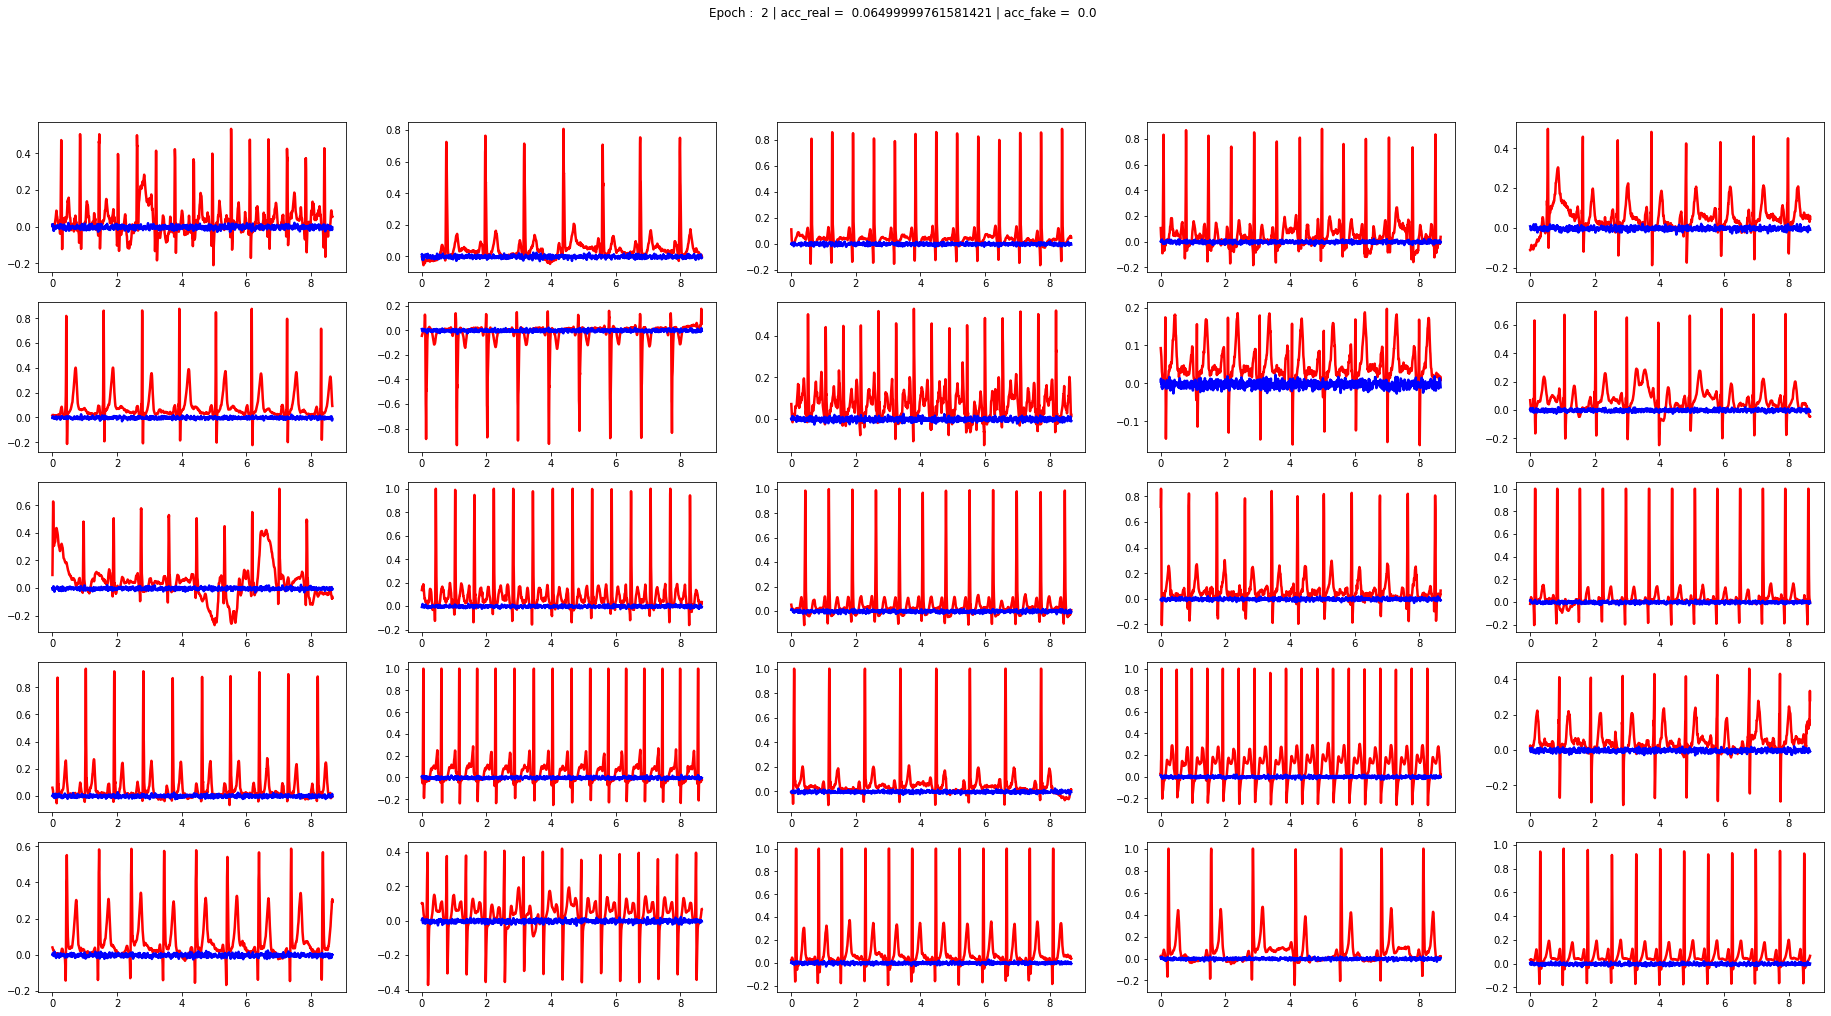

Error in callback <function flush_figures at 0x7f9be06ea598> (for post_execute):


KeyboardInterrupt: ignored

In [0]:
# ukladanie priebehu ucenia GAN - grid signalov 5x5

def save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5):

  # vykreslenie signalov
  time_axis=np.linspace(0,length_of_signal/360,length_of_signal)
  fig = plt.figure(figsize=(32,16))
  fig.suptitle('Epoch :'+ "  " + str(epoch)+" | "+'acc_real ='+"  "+str(acc_real)+" | "+'acc_fake ='+"  "+str(acc_fake))
  for i in range(n * n):
    mysignals = [{'name': 'Real signal', 'x': time_axis, 'y': x_real[i], 'color':'r', 'linewidth':2.5},{'name': 'Fake signal', 'x': time_axis, 'y': x_fake[i], 'color':'b', 'linewidth':2.5}]
    for signal in mysignals:
      ax1 = fig.add_subplot(n, n, 1 + i)
      ax1.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])

  #ulozenie obrazku signalov na google disk
  plt.savefig(str(WORKDIR_PATH / "GAN/train6/epoch") + str(epoch))

# evaluacia modelu a ukladnie priebehu ucenia gan

def summarize_performance(epoch, g_model, d_model, SI2_II_11_test, latent_dim, batch_size, mu, sigma,length_of_signal):
	# evaluacia testovacich signalov
	x_real, y_real = generate_real_samples(batch_size,SI2_II_11_test)
	_, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
	# evaluacia falosnych vygenerovanych signalov
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_size, mu, sigma)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# vyhodnotenie 
	print('>Acc Test Real: %.0f%%, Acc Fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # ulozenie obrazkov priebehu ucenia GAN
	save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5)
	# ulozenie modelu generatoru
	g_model.save(str(WORKDIR_PATH / "GAN/train6/generatormodel") + str(epoch))
  

# trenovanie modelu GAN

def train(g_model, d_model, gan_model, latent_dim, signal_train, signal_test, mu, sigma,length_of_signal, n_epochs=100, batch_size=200, n_eval=2):
  #polovica velkosti skupiny a pocet iteracii jednej epochy
  batch_per_epoch = int( SI2_II_11.shape[1] / batch_size)
  half_batch = int(batch_size / 2)

  #epocha
  for i in range(n_epochs):
    # iteracia
    for j in range(batch_per_epoch):
      # vygenerovanie realnych signalov a trening diskriminatoru
      x_real,y_real = generate_real_samples(half_batch,signal_train)
      loss_real,acc_real = d_model.train_on_batch(x_real, y_real)
      # vygenerovanie falosnych signalov a trening diskriminatoru
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch, mu, sigma)
      loss_fake, acc_fake = d_model.train_on_batch(x_fake, y_fake)  
      # vygenerovanie latentnych bodov
      x_gan = generate_latent_points(latent_dim, batch_size,mu,sigma)
      # prevratenie oznacenia triedy falosnych signalov na realne
      y_gan = ones((batch_size, 1))
      # trening generatoru
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      # ulozenie presnosti a chyb modelov
      d_real_loss_graph_sgd5.append(loss_real)
      d_real_acc_graph_sgd5.append(acc_real)
      d_fake_loss_graph_sgd5.append(loss_fake)
      d_fake_acc_graph_sgd5.append(acc_fake)
      g_loss_graph_sgd5.append(g_loss)
      #ukladanie chyb na disk v pripade straty pripojenia/zlyhania
      np.save(WORKDIR_PATH / "d_real_loss_graph_sgd5",d_real_loss_graph_sgd5)
      np.save(WORKDIR_PATH / "d_real_acc_graph_sgd5",d_real_acc_graph_sgd5)
      np.save(WORKDIR_PATH / "d_fake_loss_graph_sgd5",d_fake_loss_graph_sgd5)
      np.save(WORKDIR_PATH / "d_fake_acc_graph_sgd5",d_fake_acc_graph_sgd5)
      np.save(WORKDIR_PATH / "g_loss_graph_sgd5",g_loss_graph_sgd5)
      # priebezne vysledky modelu
      print('>%d, %d/%d, d_real=%.0f%% d_fake=%.0f%%     		d_loss=%f  g_loss=%f' % (i+1,j+1,batch_per_epoch, acc_real*100, acc_fake*100, (loss_real+loss_fake), g_loss))
    # krok evaluacie modelu a ukladania priebehu ucenia GAN
    if (i+1) % n_eval == 0:
      summarize_performance(i+1, g_model, d_model, signal_test, latent_dim, batch_size, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal)

# vytvorenie trenovacej a testovacej databazy 80/20 

number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]
print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))

# statististiky signalov pre specificke rozlozenie latentnych bodov
SI2_II_11_train_mean=np.mean(np.mean(SI2_II_11_train, axis=0))
SI2_II_11_train_std=np.mean(np.std(SI2_II_11_train, axis=0))
print('Mean of SI2_II_11_train_mean :')
print(SI2_II_11_train_mean)
print('Std of SI2_II_11_train_std :')
print(SI2_II_11_train_std)

d_real_loss_graph_sgd5=[]
d_real_acc_graph_sgd5=[]
d_fake_loss_graph_sgd5=[]
d_fake_acc_graph_sgd5=[]
g_loss_graph_sgd5=[]

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, SI2_II_11_train, SI2_II_11_test, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal, n_epochs=100, batch_size=200, n_eval=2)



### Analyze GAN performance

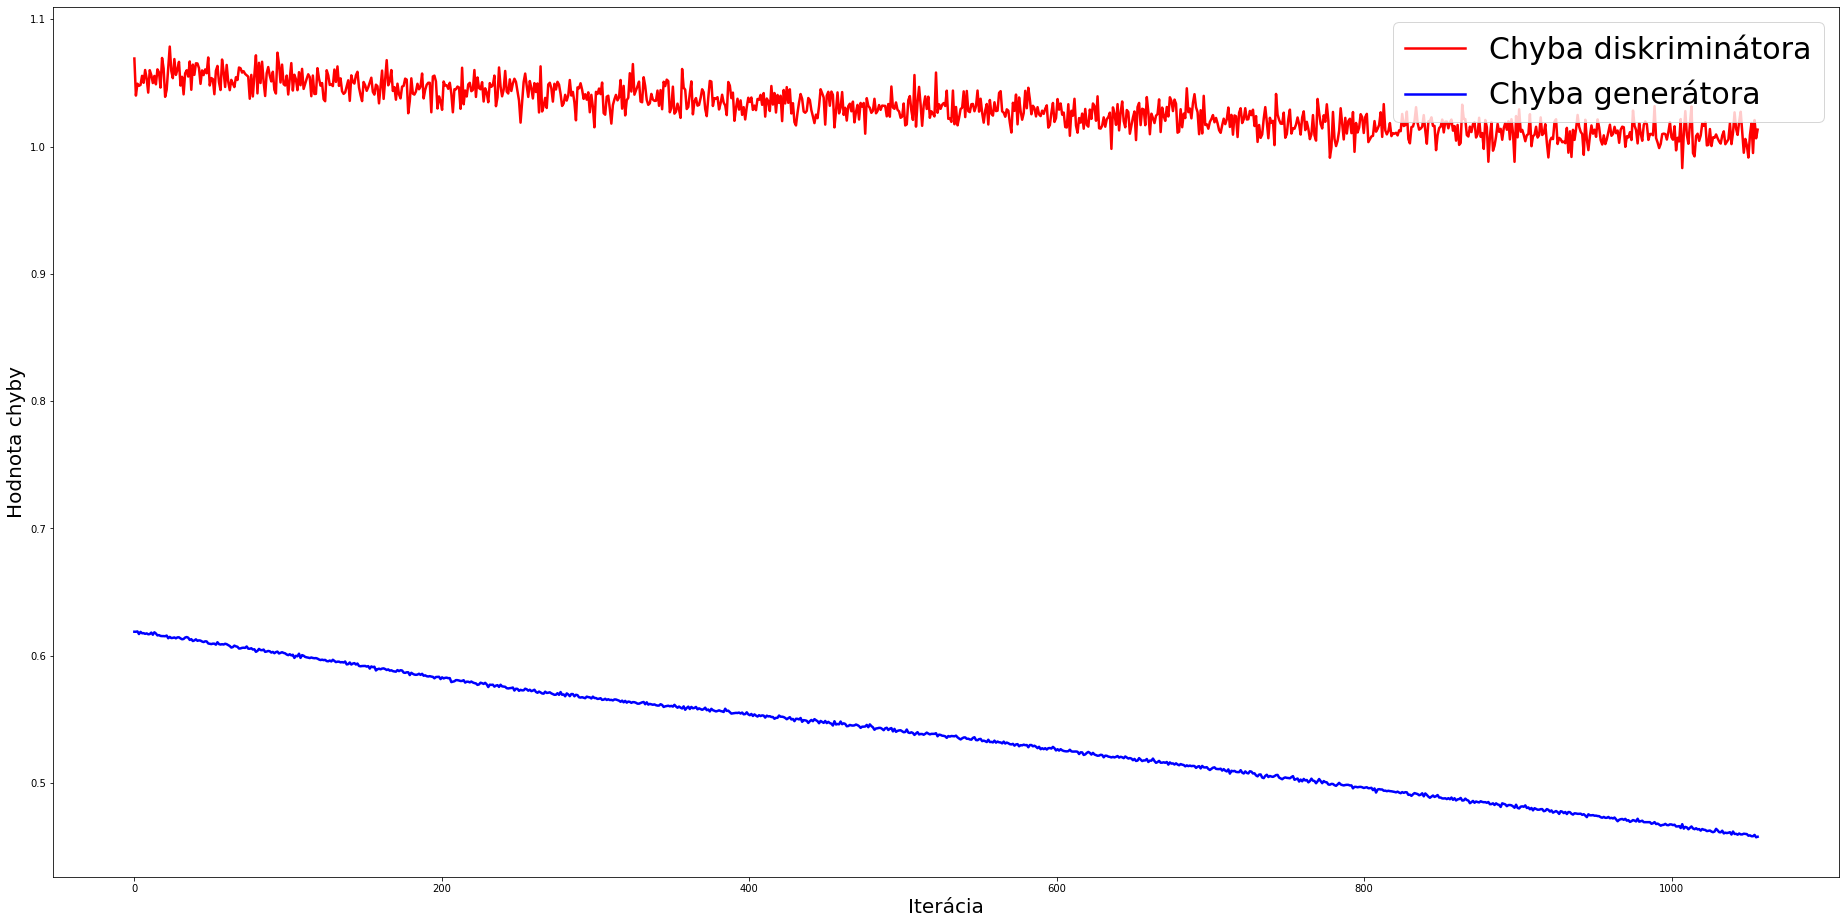

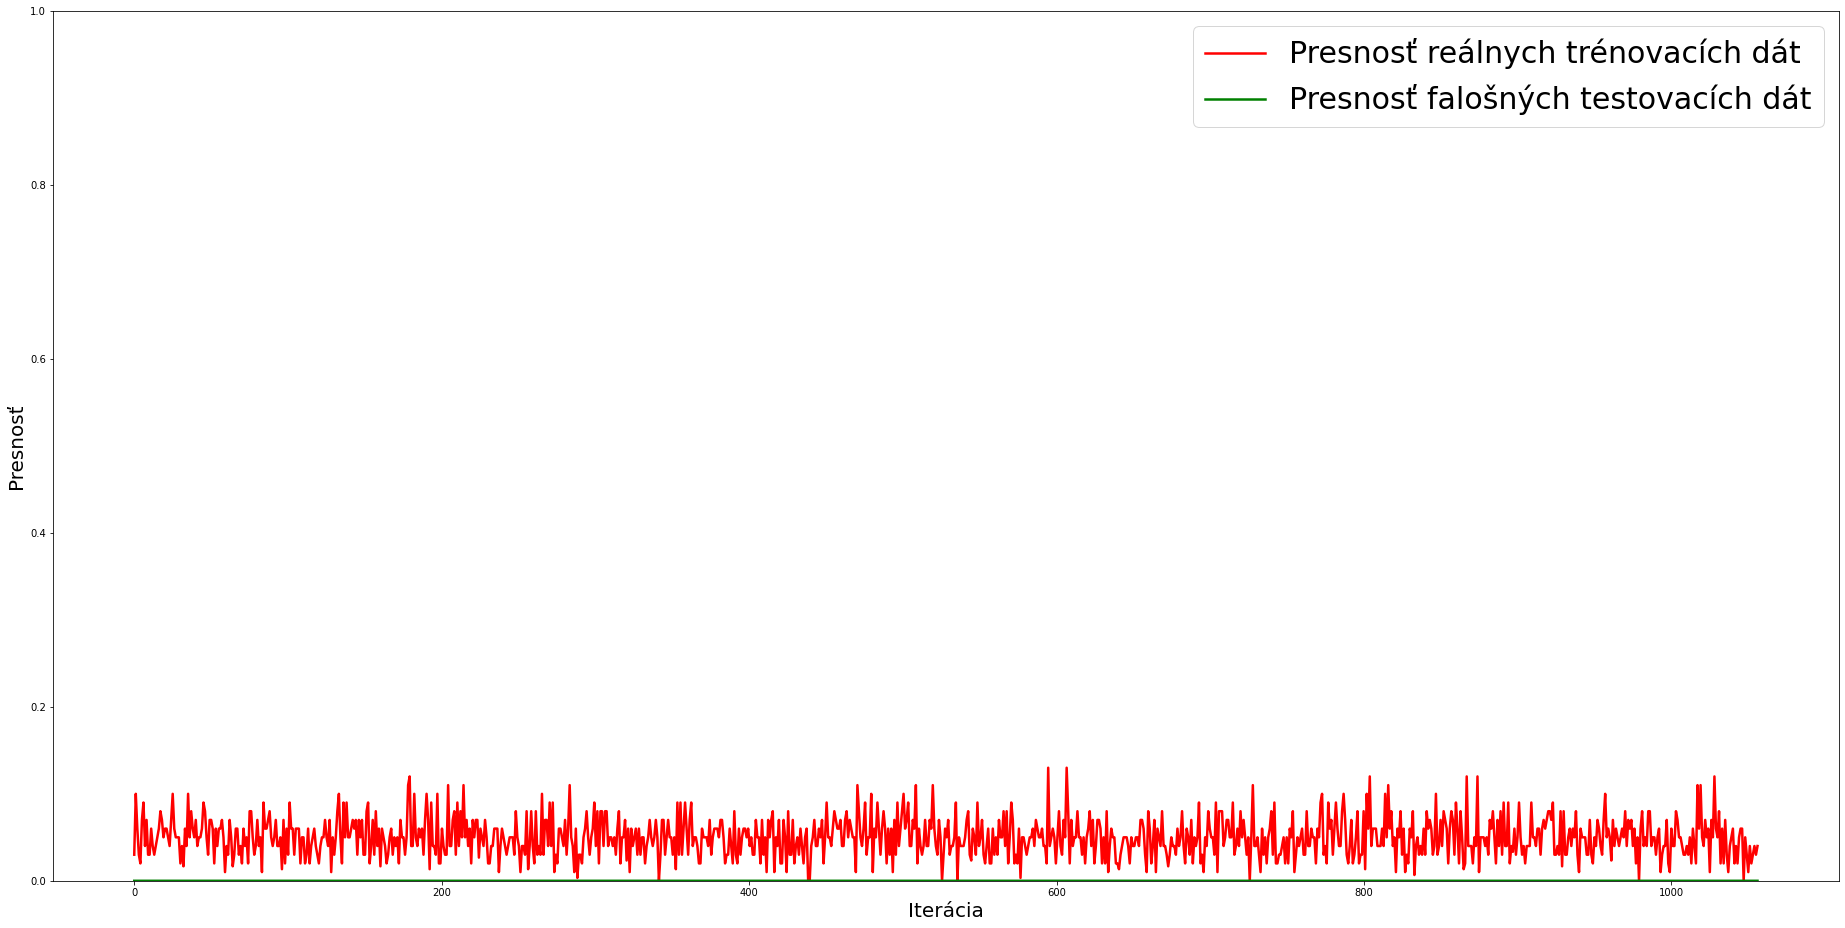

In [0]:
#chyba diskriminatoru a generatoru - #1140 iteracii -510min (8 a pol h)
d_fake_loss_graph_sgd5=np.load(WORKDIR_PATH / "d_fake_loss_graph_sgd5.npy") 
d_real_loss_graph_sgd5=np.load(WORKDIR_PATH / "d_real_loss_graph_sgd5.npy") 
d_loss_total_sgd5=np.array(d_real_loss_graph_sgd5)+np.array(d_fake_loss_graph_sgd5) 
g_loss_graph_sgd5=np.load(WORKDIR_PATH / "g_loss_graph_sgd5.npy")

#prenost diskriminatoru - #1140 iteracii -510min (8 a pol h)
d_real_acc_graph_sgd5=np.load(WORKDIR_PATH / "d_real_acc_graph_sgd5.npy")
d_fake_acc_graph_sgd5=np.load(WORKDIR_PATH / "d_fake_acc_graph_sgd5.npy")

# filtered_acc_real2 = [ item for i,item in enumerate(d_real_acc_graph2) if i%100==0 ]
# filtered_acc_fake2 = [ item for i,item in enumerate(d_fake_acc_graph2) if i%100==0 ]

iterations=int(np.array(np.shape(d_fake_loss_graph_sgd5)))

time_axis=np.linspace(0,iterations,iterations)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba diskriminátora', 'x': time_axis, 'y': d_loss_total_sgd5[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba generátora', 'x': time_axis, 'y': g_loss_graph_sgd5[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Hodnota chyby',fontsize=20)


fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť reálnych trénovacích dát', 'x': time_axis, 'y': d_real_acc_graph_sgd5[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť falošných testovacích dát', 'x': time_axis, 'y': d_fake_acc_graph_sgd5[:], 'color':'g', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Presnosť',fontsize=20)
  plt.ylim(0,1)